# Clustering initialization

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
# This will automatically reload modules before executing code that depends on them.

from copy import deepcopy

# 3rd party imports
import networkx as nx
import numpy as np
np.set_printoptions(linewidth=1000)
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pprint import pprint

# local imports
from modules import laplacian, jacobian
from modules.data import Data
import cluster

## Functions

In [2]:
from modules.laplacian import createA

def compute_error(resolution, mpoints, fpoints, deformation):
    """Compute the error between the deformation and the expected values."""
    A, Zd, Yd, Xd = createA(np.zeros((1, resolution[0], resolution[1])), mpoints, fpoints)
    dx = deformation[2, 0, :, :]
    dy = deformation[1, 0, :, :]
    dz = deformation[0, 0, :, :]

    residual_x = A @ dx.flatten() - Xd
    residual_y = A @ dy.flatten() - Yd
    residual_z = A @ dz.flatten() - Zd

    err_x = np.linalg.norm(residual_x)
    err_y = np.linalg.norm(residual_y)
    err_z = np.linalg.norm(residual_z)
    total_err = np.linalg.norm(residual_x + residual_y + residual_z)
    return err_x, err_y, err_z, total_err

In [3]:
import matplotlib.image as mpimg
from scipy.ndimage import zoom
from scipy.ndimage import geometric_transform
from functools import partial

# Load png function
def load_png(file_path: str, scale: float = 1.0, alpha: float = 1.0):
    """Load a color PNG image and return it as a numpy array, with scaling and alpha."""
    img_array = mpimg.imread(file_path)  # shape: (H, W, 3) or (H, W, 4)
    if img_array.ndim == 2:  # Grayscale image
        img_array = np.stack((img_array,) * 3, axis=-1)  # Convert to RGB
    # Only scale height and width, not channels
    if scale != 1.0:
        img_array = zoom(img_array, (scale, scale, 1), order=1)
    # If overlay is not RGBA, convert to RGBA
    if img_array.shape[-1] == 3:
        alpha_channel = np.ones(img_array.shape[:2], dtype=img_array.dtype) * alpha
        img_array = np.dstack((img_array, alpha_channel))
    else:
        img_array[..., 3] = alpha  # Set alpha for all pixels
    return img_array


# Show color png
def show_png(image_array, title=None):
    """Display a color image using matplotlib, compositing transparent pixels over white."""
    if image_array.shape[-1] == 4:  # RGBA
        rgb = image_array[..., :3]
        alpha = image_array[..., 3:4]
        white = np.ones_like(rgb)
        # Composite over white: out = alpha*rgb + (1-alpha)*white
        img = alpha * rgb + (1 - alpha) * white
    else:
        img = image_array
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()
    
    
def show_2_pngs(image1, image2, title1=None, title2=None):
    """Display two color images side by side using matplotlib."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    if image1.shape[-1] == 4:  # RGBA
        rgb1 = image1[..., :3]
        alpha1 = image1[..., 3:4]
        white1 = np.ones_like(rgb1)
        img1 = alpha1 * rgb1 + (1 - alpha1) * white1
    else:
        img1 = image1
    
    if image2.shape[-1] == 4:  # RGBA
        rgb2 = image2[..., :3]
        alpha2 = image2[..., 3:4]
        white2 = np.ones_like(rgb2)
        img2 = alpha2 * rgb2 + (1 - alpha2) * white2
    else:
        img2 = image2
    
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(title1)
    axes[0].axis('off')
    
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(title2)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    

def shift3Dfunc(point, dx, dy, dz):
    try:
        px = point[0] + dx[point[0], point[1],  point[2]]
        py = point[1] + dy[point[0], point[1],  point[2]]
        pz = point[2] + dz[point[0], point[1],  point[2]]
        if(px<0 or px> dx.shape[0]):
            return (point[0], point[1], point[2])
        if(py<0 or py> dx.shape[1]):
            return (point[0], point[1], point[2])
        if(pz<0 or pz> dx.shape[2]):
            return (point[0], point[1], point[2])
        return (px, py, pz)
    except:
        return (0, 0, 0)

def apply_transformation(d, moving_image, mpoints=None, fpoints=None, title="Transformed image"):
    #print(moving_image.shape)
    ch0 = moving_image[:, :]
    ch0 = ch0[np.newaxis, :, :]  # Add a new axis for the channel dimension

    deformation_field = d.deformation  # Get the deformation field (dx, dy, dz)
    
    # Convert all displacements to rounded integers
    #deformation_field = np.round(deformation_field).astype(np.int32)
    
    transformed_ch0 = geometric_transform(ch0, 
                                          partial(shift3Dfunc, dx=deformation_field[0], dy=deformation_field[1], dz=deformation_field[2]), order=1, prefilter=False)
    transformedData = transformed_ch0  # Use only the first channel for now
    transformedData = transformedData[0, :, :]  # Get the first channel only
    # Binarize the transformed image
    #transformedData = (transformedData > 0.5).astype(np.float32)  # Binarize the image
    
    plt.figure(figsize=(10, 10))
    plt.imshow(transformedData, cmap='gray')
    
    # Overlay the moving image points and fixed image points
    if mpoints is not None and fpoints is not None:
        for i in range(mpoints.shape[0]):
            #plt.arrow(mpoints[i, 2], mpoints[i, 1], fpoints[i, 2] - mpoints[i, 2], fpoints[i, 1] - mpoints[i, 1],
            #          head_width=0.15, head_length=0.15, fc='b', ec='b', alpha=0.5)
            #plt.text(mpoints[i, 2], mpoints[i, 1] + 0.4, str(i), color='green', ha='center', va='bottom', fontsize=8, weight='bold', alpha=0.25)
            plt.scatter(mpoints[i, 2], mpoints[i, 1], color='red', s=5, alpha=0.25)
            plt.scatter(fpoints[i, 2], fpoints[i, 1], color='green', s=5, alpha=0.1)
    plt.title(title)
    plt.legend(['Moving Points', 'Fixed Points'], loc='upper right')
    plt.show()
    return transformedData

In [4]:
def shift3Dfunc(point, dx, dy, dz):
    try:
        # For reverse mapping: for each output (fixed) voxel, find the corresponding input (moving) voxel
        # So, for each (z, y, x) in the output, we want to sample from (z - dz, y - dy, x - dx) in the input
        px = point[0] - dx[point[0], point[1], point[2]]
        py = point[1] - dy[point[0], point[1], point[2]]
        pz = point[2] - dz[point[0], point[1], point[2]]
        # Check bounds
        if px < 0 or px >= dx.shape[0]:
            return (point[0], point[1], point[2])
        if py < 0 or py >= dx.shape[1]:
            return (point[0], point[1], point[2])
        if pz < 0 or pz >= dx.shape[2]:
            return (point[0], point[1], point[2])
        return (px, py, pz)
    except:
        return (0, 0, 0)

def apply_transformation(d, moving_image, mpoints=None, fpoints=None, title="Transformed image"):
    # Prepare input image for geometric_transform
    ch0 = moving_image[:, :]
    ch0 = ch0[np.newaxis, :, :]  # Add a new axis for the channel dimension

    deformation_field = d.deformation  # (dz, dy, dx) or (channels, ...)

    # Use geometric_transform to map output (fixed) coordinates to input (moving) coordinates
    transformed_ch0 = geometric_transform(
        ch0,
        partial(
            shift3Dfunc,
            dx=deformation_field[0],
            dy=deformation_field[1],
            dz=deformation_field[2]
        ),
        order=1,
        prefilter=False
    )
    transformedData = transformed_ch0[0, :, :]  # Use only the first channel

    plt.figure(figsize=(10, 10))
    plt.imshow(transformedData, cmap='gray')

    # Overlay the moving image points and fixed image points
    if mpoints is not None and fpoints is not None:
        for i in range(mpoints.shape[0]):
            plt.scatter(mpoints[i, 2], mpoints[i, 1], color='red', s=5, alpha=0.25)
            plt.scatter(fpoints[i, 2], fpoints[i, 1], color='green', s=5, alpha=0.1)
    plt.title(title)
    plt.legend(['Moving Points', 'Fixed Points'], loc='upper right')
    plt.show()
    return transformedData

## Compare point correspondences


=== Example 2: Random point correspondences ===
Plotted 20 point correspondences
Set 1 - X range: [2.1, 96.6], Y range: [4.6, 97.0]
Set 2 - X range: [-7.5, 95.8], Y range: [-4.0, 108.5]
Correspondence distances - Mean: 11.65, Std: 4.54, Max: 19.71


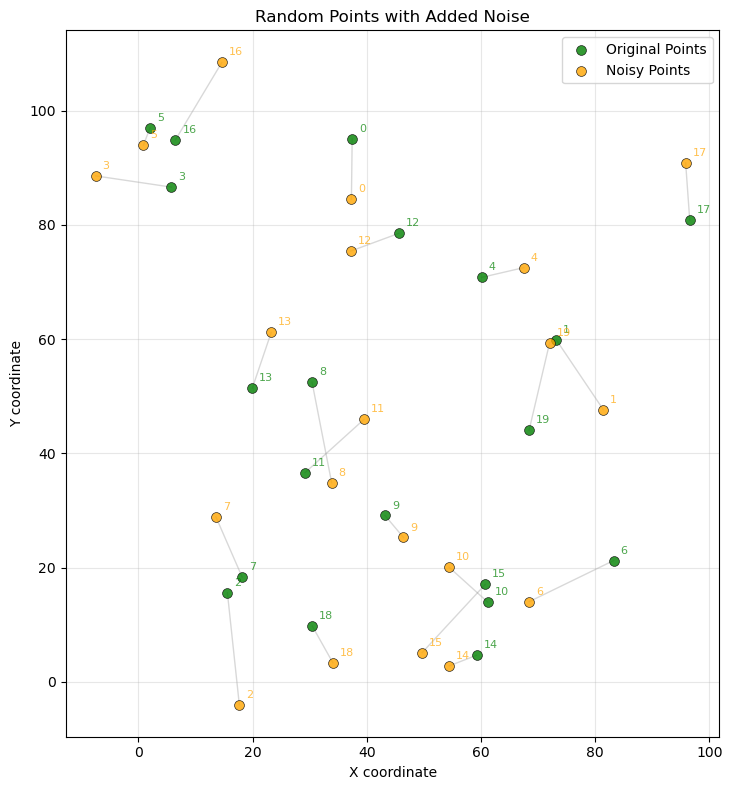


=== Example 3: Circle to ellipse transformation ===
Plotted 30 point correspondences
Set 1 - X range: [50.0, 150.0], Y range: [50.3, 149.7]
Set 2 - X range: [82.8, 217.2], Y range: [51.8, 148.2]
Correspondence distances - Mean: 58.73, Std: 14.59, Max: 83.64


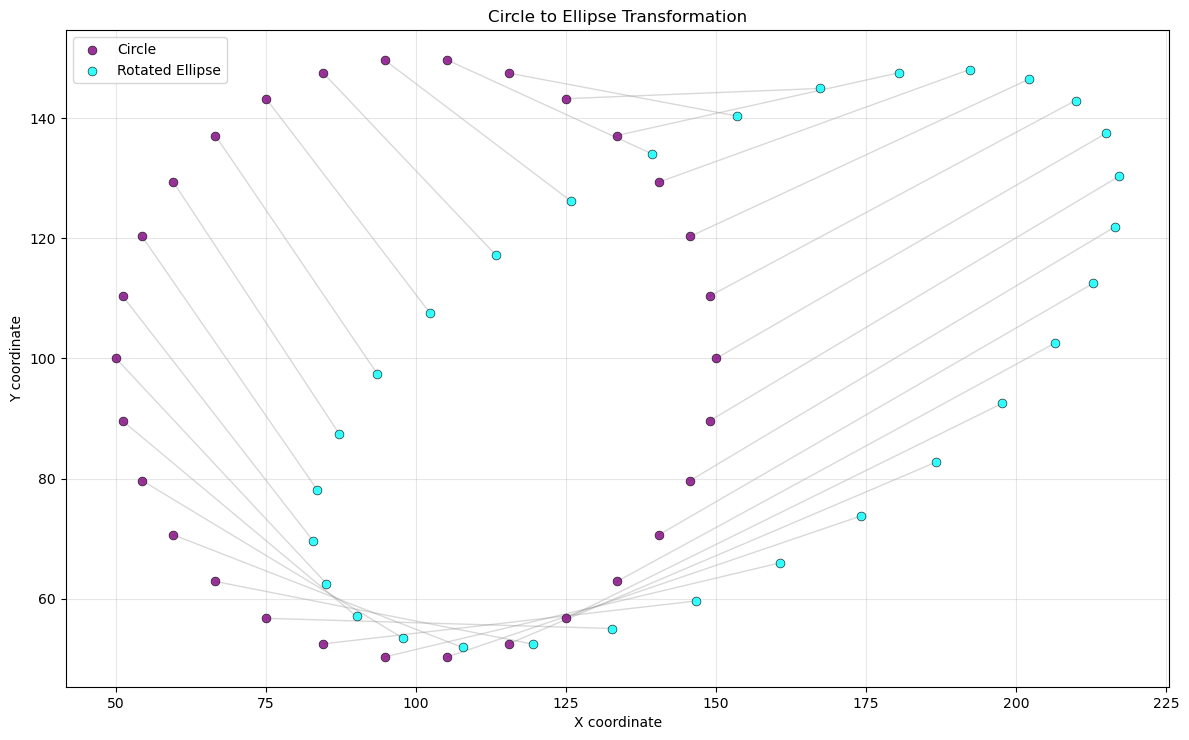

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Circle to Ellipse Transformation'}, xlabel='X coordinate', ylabel='Y coordinate'>)

In [5]:
# Example 2: Create random point sets and show correspondences
print("\n=== Example 2: Random point correspondences ===")
np.random.seed(42)  # For reproducibility

# Generate random points
n_points = 20
random_points1 = np.random.rand(n_points, 2) * 100
random_points2 = random_points1 + np.random.normal(0, 10, (n_points, 2))  # Add noise

cluster.plot_point_correspondences(random_points1, random_points2,
                          labels=('Original Points', 'Noisy Points'),
                          colors=('green', 'orange'),
                          title='Random Points with Added Noise',
                          show_indices=True,  # Show indices for smaller set
                          point_size=50)

# Example 3: Circle to ellipse transformation
print("\n=== Example 3: Circle to ellipse transformation ===")

# Create points on a circle
theta = np.linspace(0, 2*np.pi, 30, endpoint=False)
circle_points = np.column_stack([50 * np.cos(theta) + 100, 
                                50 * np.sin(theta) + 100])

# Transform to ellipse (stretch and rotate)
stretch_x, stretch_y = 1.5, 0.7
angle = np.pi/6
cos_a, sin_a = np.cos(angle), np.sin(angle)

ellipse_points = np.zeros_like(circle_points)
for i, (x, y) in enumerate(circle_points - [100, 100]):  # Center at origin
    # Apply stretching
    x_stretched = x * stretch_x
    y_stretched = y * stretch_y
    # Apply rotation
    ellipse_points[i, 0] = x_stretched * cos_a - y_stretched * sin_a + 150  # Offset
    ellipse_points[i, 1] = x_stretched * sin_a + y_stretched * cos_a + 100

cluster.plot_point_correspondences(circle_points, ellipse_points,
                          labels=('Circle', 'Rotated Ellipse'),
                          colors=('purple', 'cyan'),
                          title='Circle to Ellipse Transformation',
                          show_indices=False,
                          point_size=40)

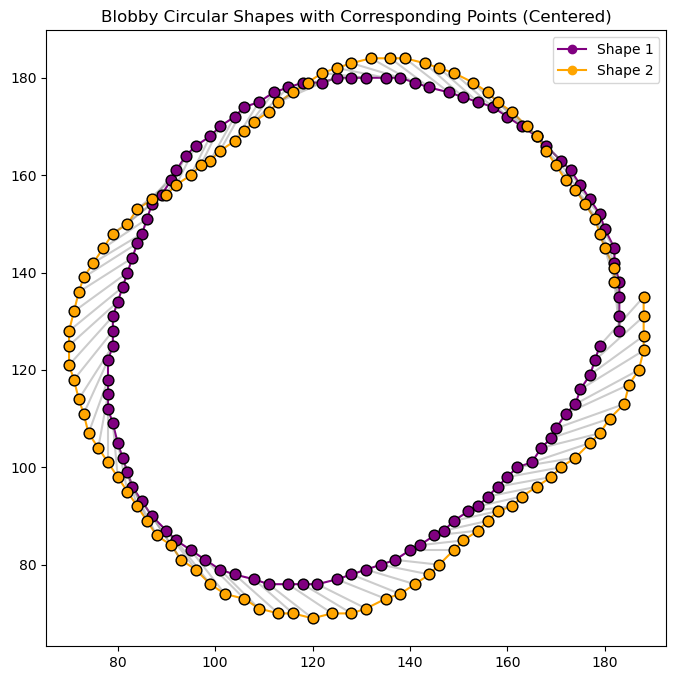

In [6]:
def create_blobby_circular_shapes(n_points=30, noise_scale=4, seed=42, plot=True):
    """
    Create two blobby, mostly circular polygon-like shapes with corresponding points.
    Ensures the points do not intersect each other on the same shape.
    Both shapes are centered around the same region.
    Returns:
        shape1_points: (N, 2) array of integers
        shape2_points: (N, 2) array of integers
    """
    np.random.seed(seed)
    theta = np.linspace(0, 2 * np.pi, n_points, endpoint=False)

    # Make radii mostly circular, with small smooth perturbations
    r1 = 50 + 4 * np.sin(2 * theta) + 2 * np.cos(3 * theta)
    r2 = 48 + 5 * np.sin(2 * theta + 0.5) + 3 * np.cos(4 * theta + 1.2)

    # Add small, smooth noise (not per-point, to avoid self-intersections)
    r1 += np.interp(theta, [0, 2*np.pi], np.random.normal(0, noise_scale, 2))
    r2 += np.interp(theta, [0, 2*np.pi], np.random.normal(0, noise_scale, 2))

    # Center both shapes at the same location
    center = np.array([128, 128])

    # Convert polar to cartesian and round to integers
    x1 = np.round(r1 * np.cos(theta) + center[0]).astype(int)
    y1 = np.round(r1 * np.sin(theta) + center[1]).astype(int)
    x2 = np.round(r2 * np.cos(theta + 0.18) + center[0]).astype(int)
    y2 = np.round(r2 * np.sin(theta + 0.18) + center[1]).astype(int)

    shape1_points = np.stack([x1, y1], axis=1)
    shape2_points = np.stack([x2, y2], axis=1)

    if plot:
        plt.figure(figsize=(8, 8))
        plt.plot(*shape1_points.T, 'o-', color='purple', label='Shape 1')
        plt.plot(*shape2_points.T, 'o-', color='orange', label='Shape 2')
        for i in range(n_points):
            plt.plot([shape1_points[i, 0], shape2_points[i, 0]],
                     [shape1_points[i, 1], shape2_points[i, 1]],
                     color='gray', alpha=0.4)
        plt.scatter(shape1_points[:, 0], shape1_points[:, 1], c='purple', s=60, edgecolors='k', zorder=3)
        plt.scatter(shape2_points[:, 0], shape2_points[:, 1], c='orange', s=60, edgecolors='k', zorder=3)
        plt.title("Blobby Circular Shapes with Corresponding Points (Centered)")
        plt.axis('equal')
        plt.legend()
        plt.show()

    return shape1_points, shape2_points

# Example usage:
shape1, shape2 = create_blobby_circular_shapes(n_points=100, plot=True, noise_scale=6)

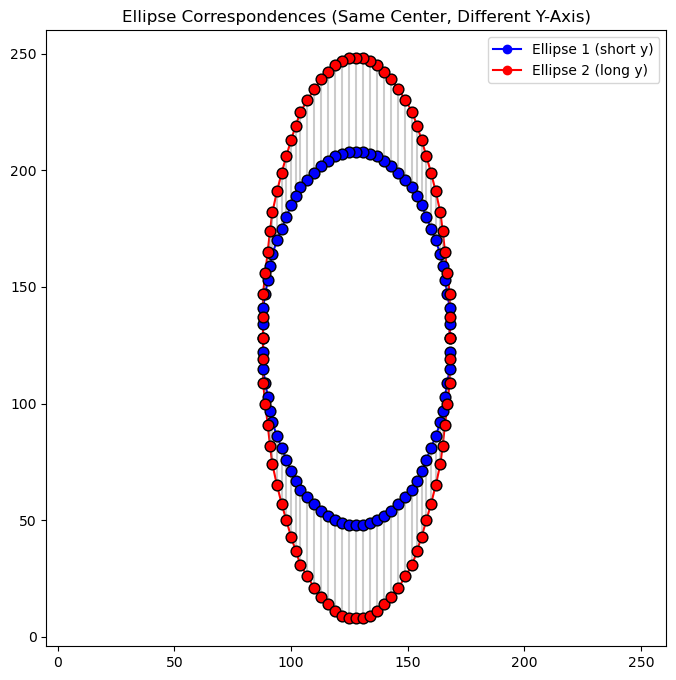

In [7]:
def create_ellipse_correspondences(n_points=30, center=(128, 128), 
                                   axes1=(40, 80), axes2=(40, 120), 
                                   angle1=0, angle2=0, seed=42, plot=True):
    """
    Create two ellipses with corresponding points, both centered at the same location.
    The second ellipse is longer along the y-axis.
    Returns:
        ellipse1_points: (N, 2) array of integers
        ellipse2_points: (N, 2) array of integers
    """
    np.random.seed(seed)
    theta = np.linspace(0, 2 * np.pi, n_points, endpoint=False)

    # First ellipse (shorter y-axis)
    x1 = axes1[0] * np.cos(theta)
    y1 = axes1[1] * np.sin(theta)
    # Second ellipse (longer y-axis)
    x2 = axes2[0] * np.cos(theta)
    y2 = axes2[1] * np.sin(theta)

    # Optionally rotate ellipses (angle in radians)
    def rotate(x, y, angle):
        xr = x * np.cos(angle) - y * np.sin(angle)
        yr = x * np.sin(angle) + y * np.cos(angle)
        return xr, yr

    x1, y1 = rotate(x1, y1, angle1)
    x2, y2 = rotate(x2, y2, angle2)

    # Center both ellipses
    x1 = np.round(x1 + center[0]).astype(int)
    y1 = np.round(y1 + center[1]).astype(int)
    x2 = np.round(x2 + center[0]).astype(int)
    y2 = np.round(y2 + center[1]).astype(int)

    ellipse1_points = np.stack([x1, y1], axis=1)
    ellipse2_points = np.stack([x2, y2], axis=1)

    if plot:
        plt.figure(figsize=(8, 8))
        plt.plot(*ellipse1_points.T, 'o-', color='blue', label='Ellipse 1 (short y)')
        plt.plot(*ellipse2_points.T, 'o-', color='red', label='Ellipse 2 (long y)')
        for i in range(n_points):
            plt.plot([ellipse1_points[i, 0], ellipse2_points[i, 0]],
                     [ellipse1_points[i, 1], ellipse2_points[i, 1]],
                     color='gray', alpha=0.4)
        plt.scatter(ellipse1_points[:, 0], ellipse1_points[:, 1], c='blue', s=60, edgecolors='k', zorder=3)
        plt.scatter(ellipse2_points[:, 0], ellipse2_points[:, 1], c='red', s=60, edgecolors='k', zorder=3)
        plt.title("Ellipse Correspondences (Same Center, Different Y-Axis)")
        plt.axis('equal')
        plt.legend()
        plt.show()

    return ellipse1_points, ellipse2_points

# Example usage:
ellipse1, ellipse2 = create_ellipse_correspondences(n_points=80, plot=True)

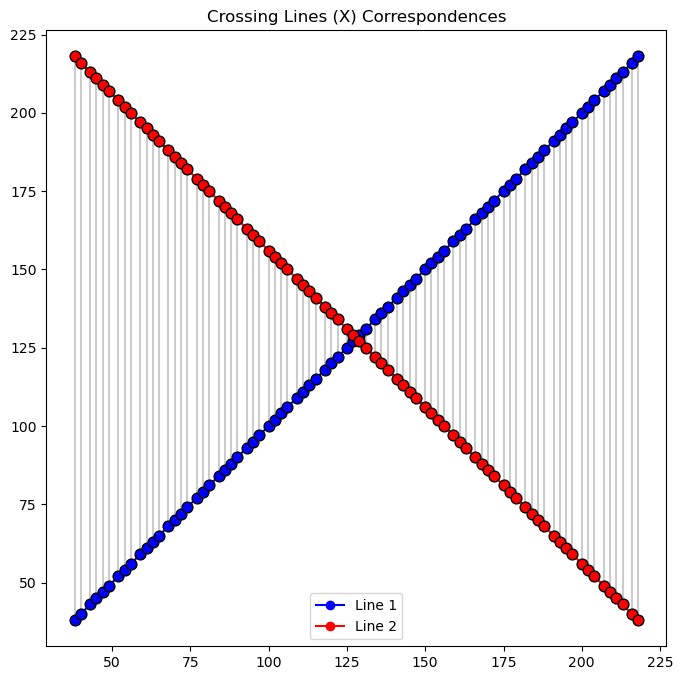

In [8]:
def create_crossing_lines_correspondences(n_points=80, center=(128, 128), length=180, plot=True):
    """
    Create two long crossing lines forming an X, with corresponding points.
    Both lines are centered at the same location.
    Returns:
        line1_points: (N, 2) array of integers
        line2_points: (N, 2) array of integers
    """
    # Line 1: from top-left to bottom-right
    x1 = np.linspace(center[0] - length // 2, center[0] + length // 2, n_points)
    y1 = np.linspace(center[1] - length // 2, center[1] + length // 2, n_points)
    # Line 2: from bottom-left to top-right
    x2 = np.linspace(center[0] - length // 2, center[0] + length // 2, n_points)
    y2 = np.linspace(center[1] + length // 2, center[1] - length // 2, n_points)

    # Round to integer pixel coordinates
    x1 = np.round(x1).astype(int)
    y1 = np.round(y1).astype(int)
    x2 = np.round(x2).astype(int)
    y2 = np.round(y2).astype(int)

    line1_points = np.stack([x1, y1], axis=1)
    line2_points = np.stack([x2, y2], axis=1)

    if plot:
        plt.figure(figsize=(8, 8))
        plt.plot(line1_points[:, 0], line1_points[:, 1], 'o-', color='blue', label='Line 1')
        plt.plot(line2_points[:, 0], line2_points[:, 1], 'o-', color='red', label='Line 2')
        for i in range(n_points):
            plt.plot([line1_points[i, 0], line2_points[i, 0]],
                     [line1_points[i, 1], line2_points[i, 1]],
                     color='gray', alpha=0.4)
        plt.scatter(line1_points[:, 0], line1_points[:, 1], c='blue', s=60, edgecolors='k', zorder=3)
        plt.scatter(line2_points[:, 0], line2_points[:, 1], c='red', s=60, edgecolors='k', zorder=3)
        plt.title("Crossing Lines (X) Correspondences")
        plt.axis('equal')
        plt.legend()
        plt.show()

    return line1_points, line2_points

# Example usage:
line1, line2 = create_crossing_lines_correspondences(n_points=80, plot=True)

Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - Y range: [25, 230], X range: [77, 179]
Wave 2 - Y range: [25, 230], X range: [77, 179]
Number of intersection points: 2


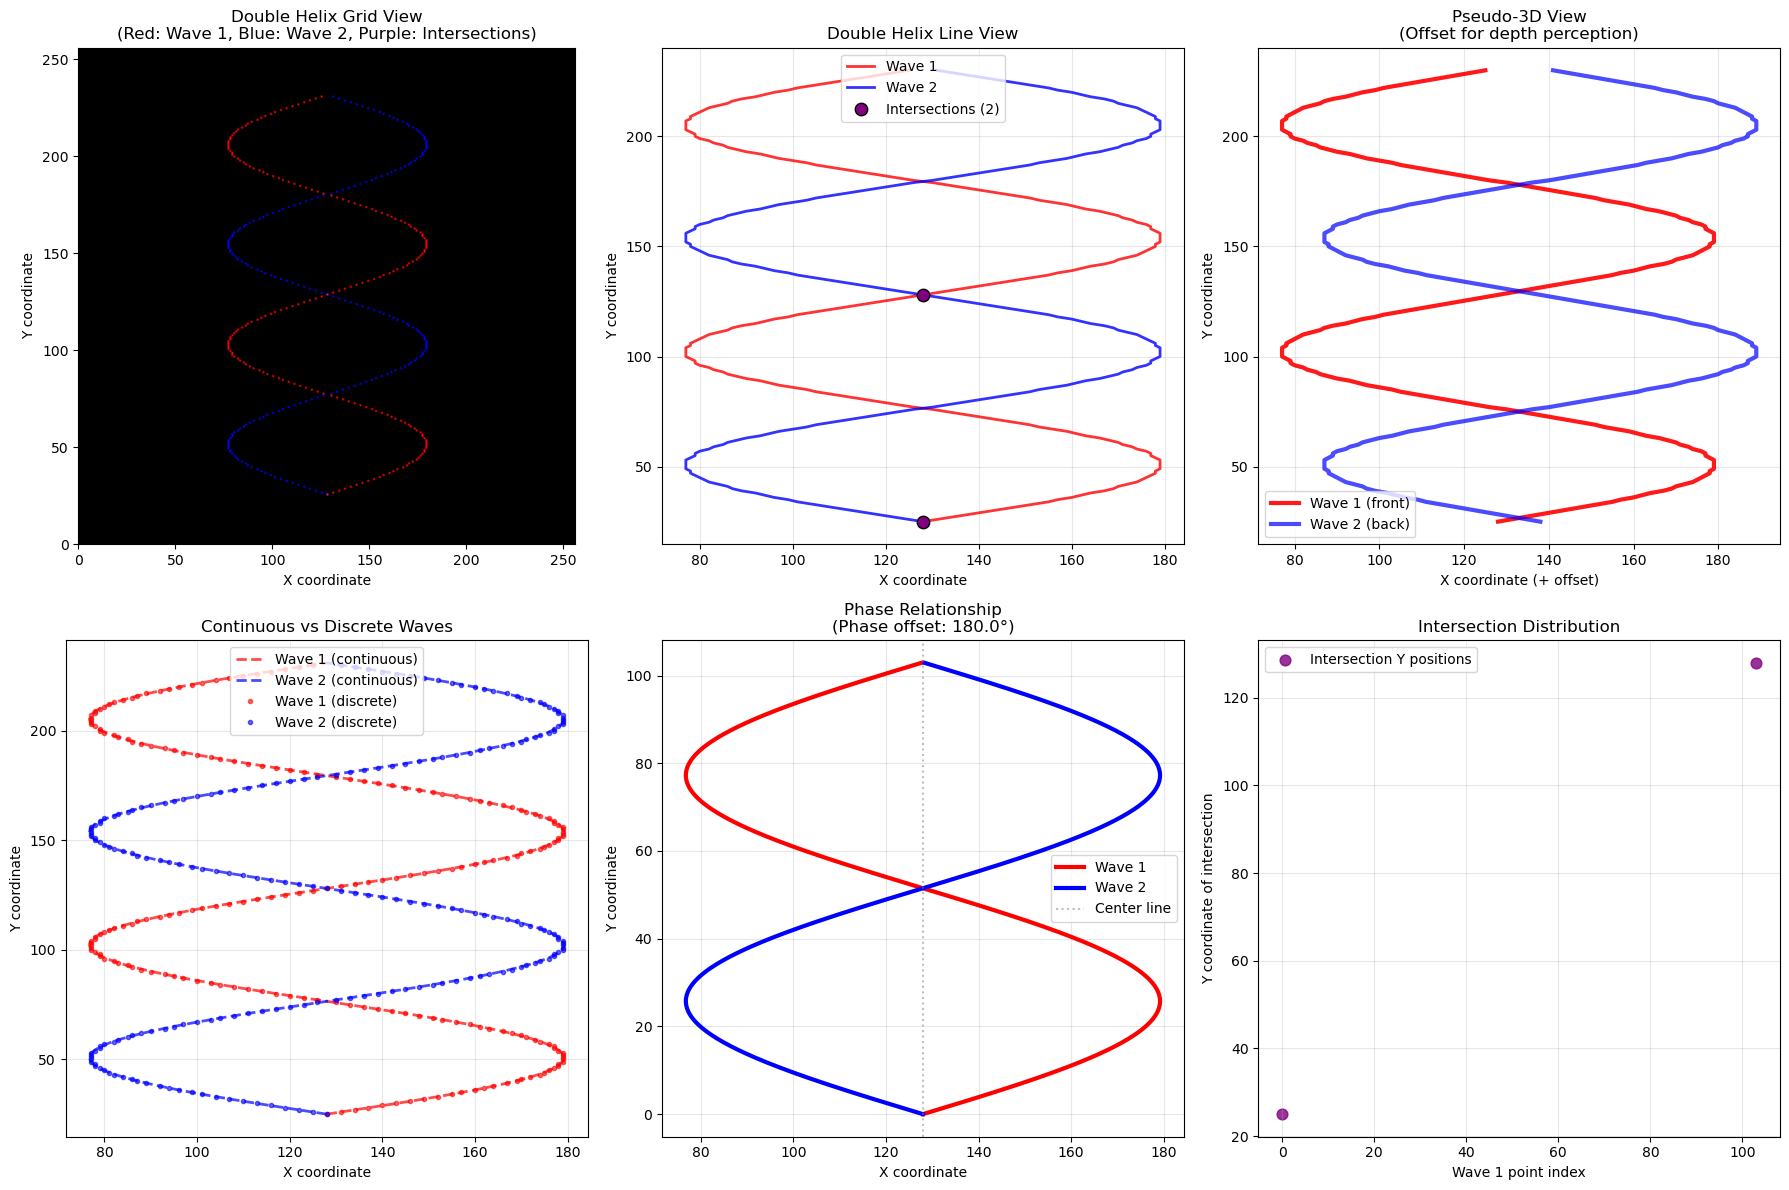

(array([[128,  25],
        [131,  26],
        [134,  27],
        [137,  28],
        [140,  29],
        [143,  30],
        [146,  31],
        [149,  32],
        [152,  33],
        [155,  34],
        [157,  35],
        [160,  36],
        [162,  37],
        [164,  38],
        [167,  39],
        [169,  40],
        [170,  41],
        [172,  42],
        [174,  43],
        [175,  44],
        [176,  45],
        [177,  46],
        [178,  47],
        [178,  48],
        [179,  49],
        [179,  50],
        [179,  51],
        [179,  52],
        [179,  53],
        [178,  54],
        [177,  55],
        [177,  56],
        [176,  57],
        [174,  58],
        [173,  59],
        [171,  60],
        [170,  61],
        [168,  62],
        [166,  63],
        [163,  64],
        [161,  65],
        [159,  66],
        [156,  67],
        [153,  68],
        [151,  69],
        [148,  70],
        [145,  71],
        [142,  72],
        [139,  73],
        [136,  74],


In [9]:
def create_double_helix_waves(grid_size=256, num_cycles=4, amplitude_ratio=0.2, 
                             vertical_center_ratio=0.5, padding_ratio=0.1, 
                             phase_offset=np.pi, plot=True, horizontal=True):
    """
    Create two intersecting sinusoidal waves that form a double helix pattern.
    If horizontal=True, the helix is oriented horizontally (waves run vertically).
    If horizontal=False, the helix is oriented vertically (waves run horizontally, original behavior).

    Parameters:
    -----------
    grid_size : int, default=256
        Size of the square grid (grid_size x grid_size)
    num_cycles : float, default=4
        Number of complete sine wave cycles across the grid
    amplitude_ratio : float, default=0.2
        Amplitude as a ratio of grid_size 
    vertical_center_ratio : float, default=0.5
        Vertical center position as ratio of grid_size (0.5 = center)
    padding_ratio : float, default=0.1
        Padding around the waves as ratio of grid_size
    phase_offset : float, default=np.pi
        Phase difference between the two waves (π creates perfect interleaving)
    plot : bool, default=True
        Whether to create plots of the waves
    horizontal : bool, default=True
        If True, helix is horizontal (waves run vertically). If False, original vertical helix.

    Returns:
    --------
    wave1_points : numpy.ndarray
        Array of (x, y) coordinates for the first wave
    wave2_points : numpy.ndarray
        Array of (x, y) coordinates for the second wave
    grid : numpy.ndarray
        2D grid with both waves marked (wave1=1, wave2=2, intersections=3)
    """

    padding = int(grid_size * padding_ratio)
    effective_grid_size = grid_size - 2 * padding

    if horizontal:
        # Swap axes: now y is the main axis, x is the wave
        y_coords = np.arange(effective_grid_size) + padding
        frequency = 2 * np.pi * num_cycles / effective_grid_size
        amplitude = grid_size * amplitude_ratio
        horizontal_center = grid_size * vertical_center_ratio

        y_wave = np.arange(effective_grid_size)
        # First wave (standard sine, runs horizontally)
        x1_coords = amplitude * np.sin(frequency * y_wave) + horizontal_center
        # Second wave (phase shifted sine)
        x2_coords = amplitude * np.sin(frequency * y_wave + phase_offset) + horizontal_center

        # Convert to integer coordinates and ensure they stay within bounds
        x1_coords_int = np.round(x1_coords).astype(int)
        x2_coords_int = np.round(x2_coords).astype(int)
        x1_coords_int = np.clip(x1_coords_int, 0, grid_size - 1)
        x2_coords_int = np.clip(x2_coords_int, 0, grid_size - 1)

        # Create points that lie on the waves (x, y)
        wave1_points = np.column_stack((x1_coords_int, y_coords))
        wave2_points = np.column_stack((x2_coords_int, y_coords))
    else:
        # Original vertical helix
        x_coords = np.arange(effective_grid_size) + padding
        frequency = 2 * np.pi * num_cycles / effective_grid_size
        amplitude = grid_size * amplitude_ratio
        vertical_center = grid_size * vertical_center_ratio

        x_wave = np.arange(effective_grid_size)
        y1_coords = amplitude * np.sin(frequency * x_wave) + vertical_center
        y2_coords = amplitude * np.sin(frequency * x_wave + phase_offset) + vertical_center

        y1_coords_int = np.round(y1_coords).astype(int)
        y2_coords_int = np.round(y2_coords).astype(int)
        y1_coords_int = np.clip(y1_coords_int, 0, grid_size - 1)
        y2_coords_int = np.clip(y2_coords_int, 0, grid_size - 1)

        wave1_points = np.column_stack((x_coords, y1_coords_int))
        wave2_points = np.column_stack((x_coords, y2_coords_int))

    # Create a 2D grid visualization
    grid = np.zeros((grid_size, grid_size))

    # Mark wave 1 points
    for x, y in wave1_points:
        grid[y, x] += 1

    # Mark wave 2 points 
    for x, y in wave2_points:
        grid[y, x] += 2

    # Find intersection points (where both waves occupy the same pixel)
    intersections = []
    for i, (x1, y1) in enumerate(wave1_points):
        for j, (x2, y2) in enumerate(wave2_points):
            if x1 == x2 and y1 == y2:
                intersections.append((i, j, x1, y1))

    print(f"Created double helix with {len(wave1_points)} points per wave")
    print(f"Grid size: {grid_size}x{grid_size}")
    print(f"Padding: {padding} pixels on each side")
    print(f"Number of cycles: {num_cycles}")
    print(f"Phase offset: {phase_offset:.3f} radians ({phase_offset*180/np.pi:.1f} degrees)")
    if horizontal:
        print(f"Wave 1 - Y range: [{wave1_points[:,1].min()}, {wave1_points[:,1].max()}], X range: [{wave1_points[:,0].min()}, {wave1_points[:,0].max()}]")
        print(f"Wave 2 - Y range: [{wave2_points[:,1].min()}, {wave2_points[:,1].max()}], X range: [{wave2_points[:,0].min()}, {wave2_points[:,0].max()}]")
    else:
        print(f"Wave 1 - X range: [{wave1_points[:,0].min()}, {wave1_points[:,0].max()}], Y range: [{wave1_points[:,1].min()}, {wave1_points[:,1].max()}]")
        print(f"Wave 2 - X range: [{wave2_points[:,0].min()}, {wave2_points[:,0].max()}], Y range: [{wave2_points[:,1].min()}, {wave2_points[:,1].max()}]")
    print(f"Number of intersection points: {len(intersections)}")

    if plot:
        fig = plt.figure(figsize=(18, 12))

        # Plot 1: Grid view showing both waves
        plt.subplot(2, 3, 1)
        display_grid = np.zeros((grid_size, grid_size, 3))  # RGB

        for x, y in wave1_points:
            display_grid[y, x, 0] = 1.0  # Red channel
        for x, y in wave2_points:
            display_grid[y, x, 2] = 1.0  # Blue channel

        plt.imshow(display_grid, origin='lower', extent=[0, grid_size, 0, grid_size])
        plt.title(f'Double Helix Grid View\n(Red: Wave 1, Blue: Wave 2, Purple: Intersections)')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')

        # Plot 2: Both waves as line plots
        plt.subplot(2, 3, 2)
        plt.plot(wave1_points[:, 0], wave1_points[:, 1], 'r-', linewidth=2, label='Wave 1', alpha=0.8)
        plt.plot(wave2_points[:, 0], wave2_points[:, 1], 'b-', linewidth=2, label='Wave 2', alpha=0.8)
        if intersections:
            intersection_x = [pt[2] for pt in intersections]
            intersection_y = [pt[3] for pt in intersections]
            plt.scatter(intersection_x, intersection_y, c='purple', s=80, 
                       marker='o', label=f'Intersections ({len(intersections)})', 
                       zorder=5, edgecolors='black')
        plt.title('Double Helix Line View')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 3: 3D-like perspective (using offset)
        plt.subplot(2, 3, 3)
        offset = 10
        if horizontal:
            plt.plot(wave1_points[:, 0], wave1_points[:, 1], 'r-', linewidth=3, label='Wave 1 (front)', alpha=0.9)
            plt.plot(wave2_points[:, 0] + offset, wave2_points[:, 1], 'b-', linewidth=3, label='Wave 2 (back)', alpha=0.7)
        else:
            plt.plot(wave1_points[:, 0], wave1_points[:, 1], 'r-', linewidth=3, label='Wave 1 (front)', alpha=0.9)
            plt.plot(wave2_points[:, 0] + offset, wave2_points[:, 1], 'b-', linewidth=3, label='Wave 2 (back)', alpha=0.7)
        plt.title('Pseudo-3D View\n(Offset for depth perception)')
        plt.xlabel('X coordinate (+ offset)')
        plt.ylabel('Y coordinate')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 4: Continuous waves for comparison
        plt.subplot(2, 3, 4)
        smooth = np.linspace(padding, grid_size-padding, 1000)
        smooth_wave = np.linspace(0, effective_grid_size, 1000)
        if horizontal:
            x1_smooth = amplitude * np.sin(frequency * smooth_wave) + horizontal_center
            x2_smooth = amplitude * np.sin(frequency * smooth_wave + phase_offset) + horizontal_center
            plt.plot(x1_smooth, smooth, 'r--', linewidth=2, alpha=0.7, label='Wave 1 (continuous)')
            plt.plot(x2_smooth, smooth, 'b--', linewidth=2, alpha=0.7, label='Wave 2 (continuous)')
            plt.plot(wave1_points[:, 0], wave1_points[:, 1], 'ro', markersize=3, alpha=0.6, label='Wave 1 (discrete)')
            plt.plot(wave2_points[:, 0], wave2_points[:, 1], 'bo', markersize=3, alpha=0.6, label='Wave 2 (discrete)')
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
        else:
            y1_smooth = amplitude * np.sin(frequency * smooth_wave) + vertical_center
            y2_smooth = amplitude * np.sin(frequency * smooth_wave + phase_offset) + vertical_center
            plt.plot(smooth, y1_smooth, 'r--', linewidth=2, alpha=0.7, label='Wave 1 (continuous)')
            plt.plot(smooth, y2_smooth, 'b--', linewidth=2, alpha=0.7, label='Wave 2 (continuous)')
            plt.plot(wave1_points[:, 0], wave1_points[:, 1], 'ro', markersize=3, alpha=0.6, label='Wave 1 (discrete)')
            plt.plot(wave2_points[:, 0], wave2_points[:, 1], 'bo', markersize=3, alpha=0.6, label='Wave 2 (discrete)')
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
        plt.title('Continuous vs Discrete Waves')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 5: Phase relationship
        plt.subplot(2, 3, 5)
        sample = smooth_wave[:500]
        if horizontal:
            x1_sample = amplitude * np.sin(frequency * sample) + horizontal_center
            x2_sample = amplitude * np.sin(frequency * sample + phase_offset) + horizontal_center
            plt.plot(x1_sample, sample, 'r-', linewidth=3, label='Wave 1')
            plt.plot(x2_sample, sample, 'b-', linewidth=3, label='Wave 2')
            plt.axvline(x=horizontal_center, color='gray', linestyle=':', alpha=0.5, label='Center line')
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
        else:
            y1_sample = amplitude * np.sin(frequency * sample) + vertical_center
            y2_sample = amplitude * np.sin(frequency * sample + phase_offset) + vertical_center
            plt.plot(sample, y1_sample, 'r-', linewidth=3, label='Wave 1')
            plt.plot(sample, y2_sample, 'b-', linewidth=3, label='Wave 2')
            plt.axhline(y=vertical_center, color='gray', linestyle=':', alpha=0.5, label='Center line')
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
        plt.title(f'Phase Relationship\n(Phase offset: {phase_offset*180/np.pi:.1f}°)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 6: Intersection analysis
        plt.subplot(2, 3, 6)
        if intersections:
            intersection_indices = [pt[0] for pt in intersections]
            if horizontal:
                plt.scatter(intersection_indices, [wave1_points[i, 1] for i in intersection_indices], 
                            c='purple', s=60, alpha=0.8, label='Intersection Y positions')
                plt.xlabel('Wave 1 point index')
                plt.ylabel('Y coordinate of intersection')
            else:
                plt.scatter(intersection_indices, [wave1_points[i, 0] for i in intersection_indices], 
                            c='purple', s=60, alpha=0.8, label='Intersection X positions')
                plt.xlabel('Wave 1 point index')
                plt.ylabel('X coordinate of intersection')
            plt.title('Intersection Distribution')
            plt.grid(True, alpha=0.3)
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'No intersections found\nat current resolution', 
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('Intersection Analysis')

        plt.tight_layout()
        plt.show()

    return wave1_points, wave2_points, grid

create_double_helix_waves(grid_size=256, num_cycles=2, amplitude_ratio=0.2, 
                           vertical_center_ratio=0.5, padding_ratio=0.1)

# Correspondence density comparison

## Full double-helix


=== Creating Double Helix for Point Correspondence ===

=== Resolution / 1 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 206 point correspondences
Set 1 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.79, Std: 4.83, Max: 16.00


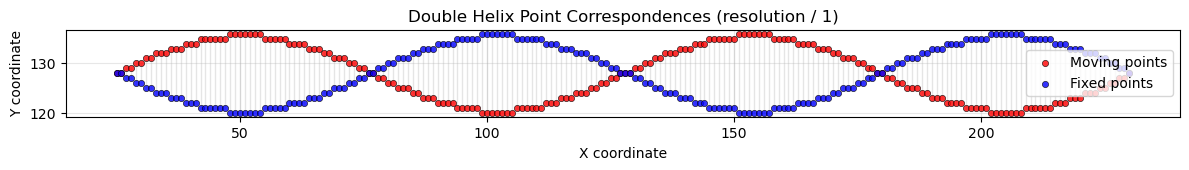

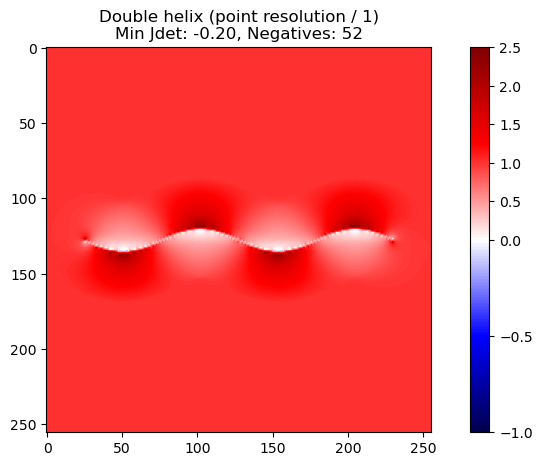


=== Resolution / 2 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 103 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.79, Std: 4.83, Max: 16.00


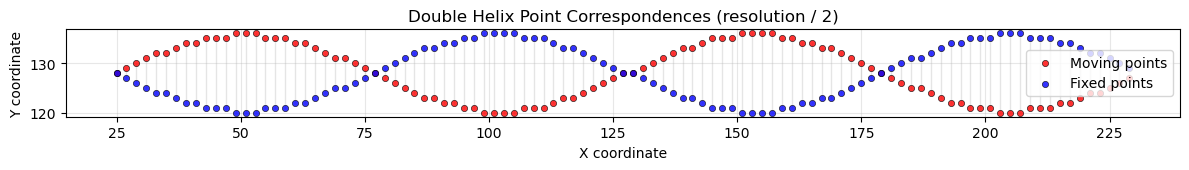

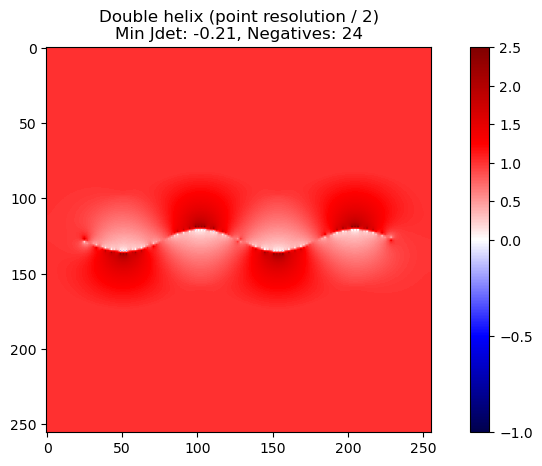


=== Resolution / 3 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 69 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.80, Std: 4.88, Max: 16.00


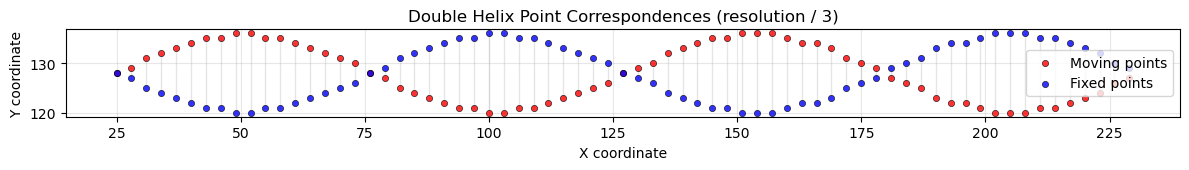

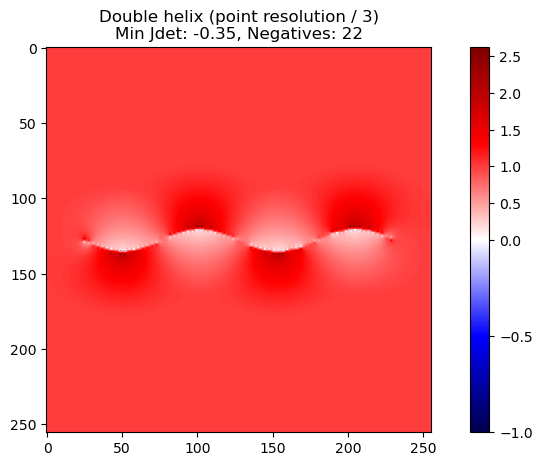


=== Resolution / 4 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 52 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.69, Std: 4.91, Max: 16.00


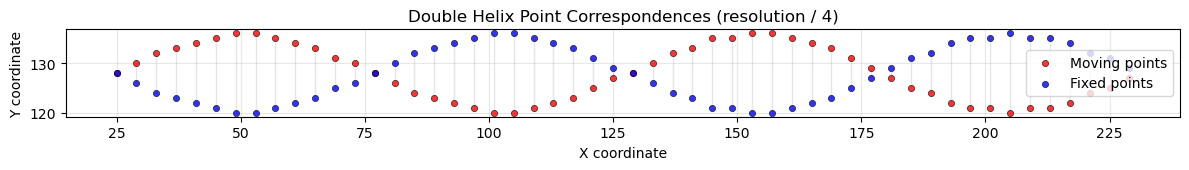

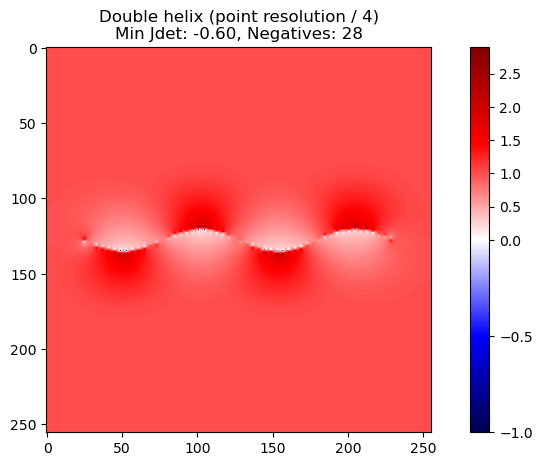


=== Resolution / 5 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 42 point correspondences
Set 1 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.57, Std: 4.93, Max: 16.00


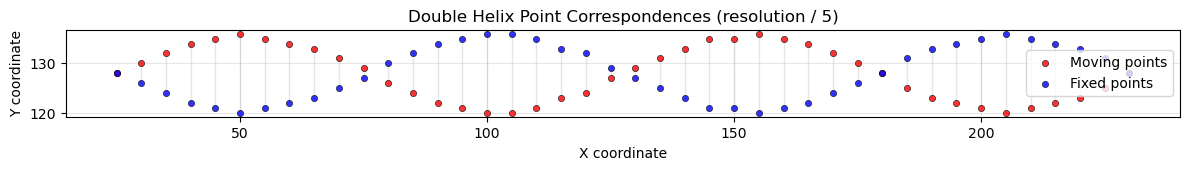

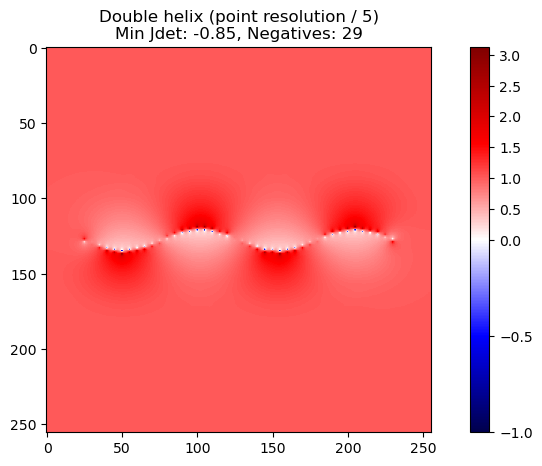


=== Resolution / 6 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 35 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.66, Std: 4.98, Max: 16.00


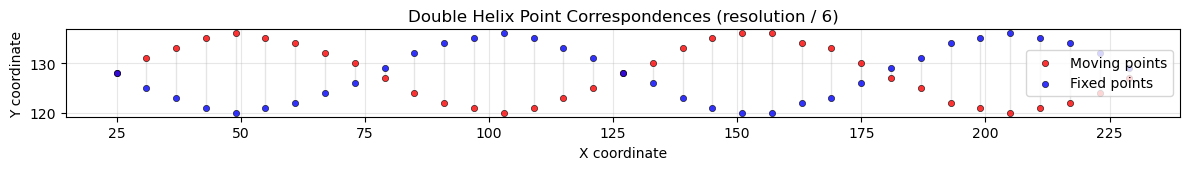

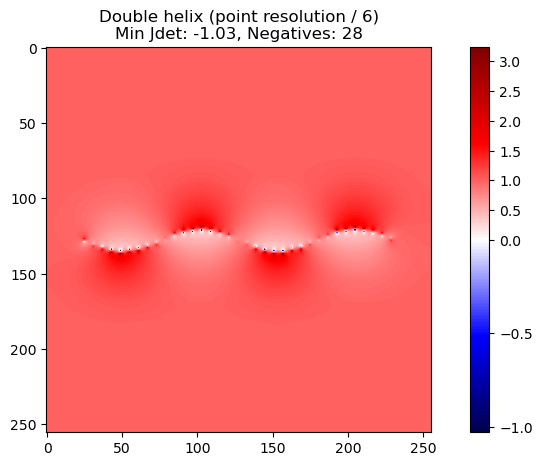


=== Resolution / 7 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 30 point correspondences
Set 1 - X range: [25.0, 228.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 228.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.47, Std: 5.08, Max: 16.00


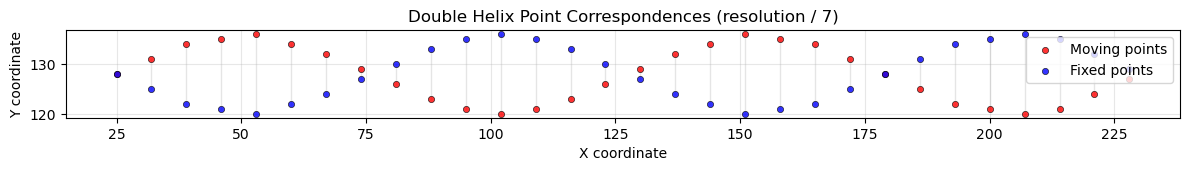

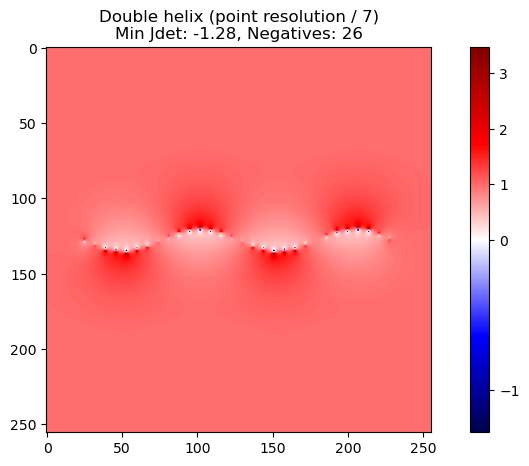


=== Resolution / 8 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 26 point correspondences
Set 1 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.77, Std: 4.85, Max: 16.00


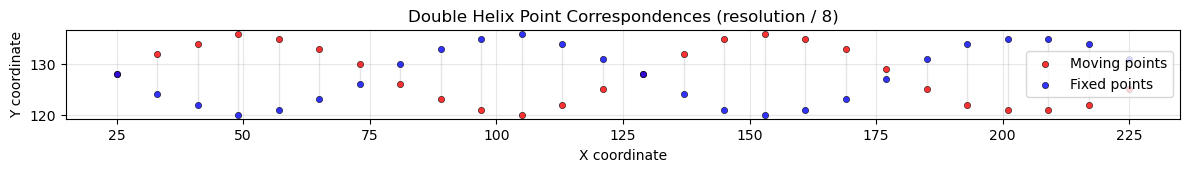

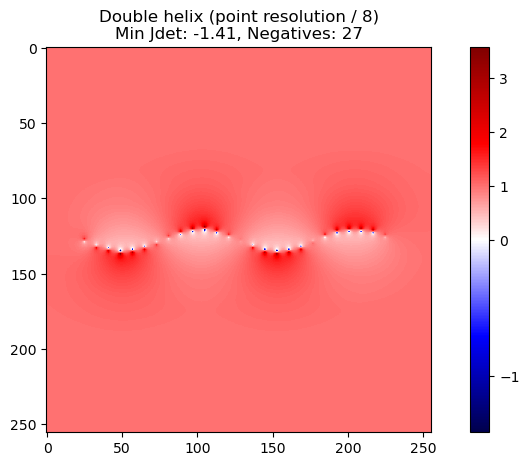


=== Resolution / 9 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 23 point correspondences
Set 1 - X range: [25.0, 223.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 223.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.74, Std: 4.84, Max: 16.00


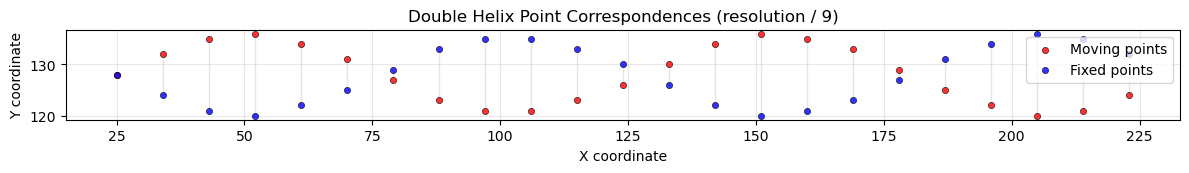

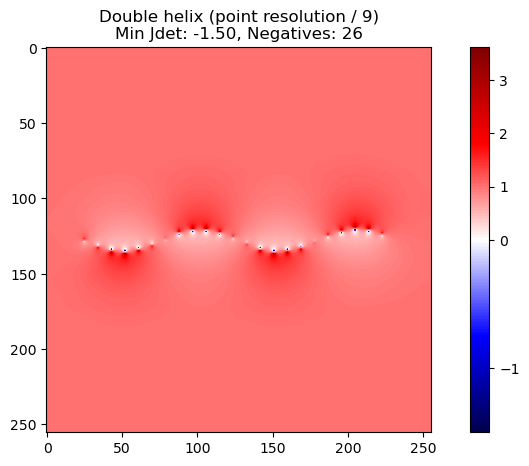


=== Resolution / 10 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 21 point correspondences
Set 1 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.62, Std: 4.88, Max: 16.00


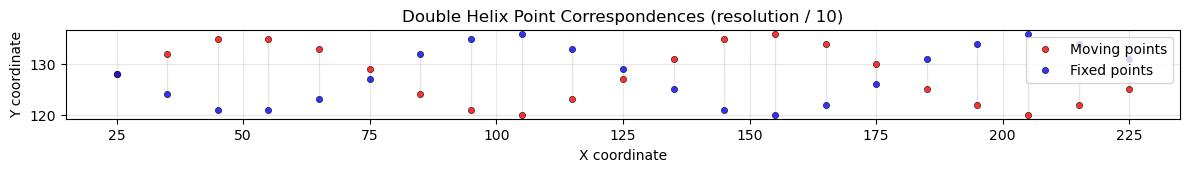

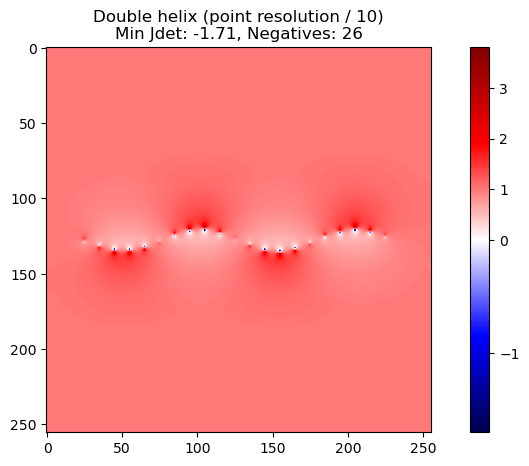

In [10]:
# Create a specific double helix for correspondence analysis
print("\n=== Creating Double Helix for Point Correspondence ===")

resolution = (256, 256)  # Example resolution for the data
points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

#####################################################################################################

for num_points_skip in points_to_skip:
    print(f"\n=== Resolution / {num_points_skip} ===")

    helix_wave1, helix_wave2, _ = cluster.create_double_helix_waves(
        grid_size=256,
        num_cycles=2,
        amplitude_ratio=0.03,
        phase_offset=np.pi,  # 180 degrees for maximum separation
        padding_ratio=0.1,
        plot=False
    )

    # Decrease point density for better visualization
    helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
    helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

    # Plot the correspondences between the two helical waves
    cluster.plot_point_correspondences(helix_wave1, helix_wave2,
                            labels=('Moving points', 'Fixed points'),
                            colors=('red', 'blue'),
                            title=f'Double Helix Point Correspondences (resolution / {num_points_skip})',
                            show_indices=False,
                            line_alpha=0.2,  # More transparent lines to show the pattern better
                            point_size=20)

    # Swap columns to match expected format (x, y)
    helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
    helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

    # Add 0s on the first axis to format for Data class
    helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
    helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

    # Run Laplacian
    d = Data(helix_wave1, helix_wave2, resolution)
    d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
           title=f"Double helix (point resolution / {num_points_skip})\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")

## Downwards cluster


=== Creating Double Helix for Point Correspondence ===

=== Resolution / 1 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 206 point correspondences
Set 1 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.79, Std: 4.83, Max: 16.00


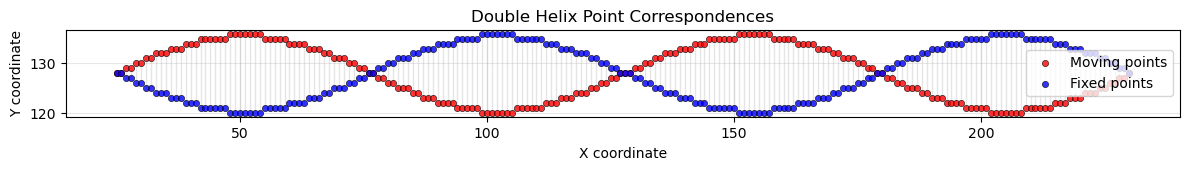

Analyzing 206 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 98 points (indices: [2, 3, 4, 5, 6]...)
  Mean displacement: Z=0.000, Y=-10.286, X=0.000
  Std displacement:  Z=0.000, Y=4.408, X=0.000
Cluster 1: 108 points (indices: [0, 1, 51, 52, 53]...)
  Mean displacement: Z=0.000, Y=9.333, X=0.000
  Std displacement:  Z=0.000, Y=5.150, X=0.000


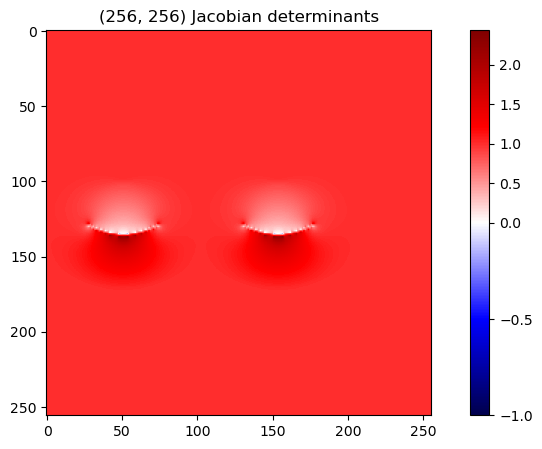

Minimum Jacobian determinant: -0.16
Number of negative Jacobian determinants: 20

=== Resolution / 2 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 103 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.79, Std: 4.83, Max: 16.00


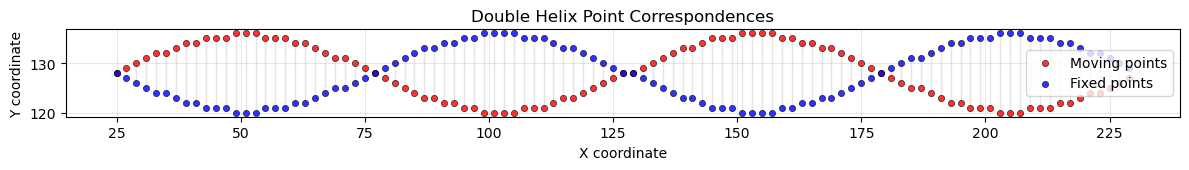

Analyzing 103 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 49 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.286, X=0.000
  Std displacement:  Z=0.000, Y=4.408, X=0.000
Cluster 1: 54 points (indices: [0, 26, 27, 28, 29]...)
  Mean displacement: Z=0.000, Y=9.333, X=0.000
  Std displacement:  Z=0.000, Y=5.150, X=0.000


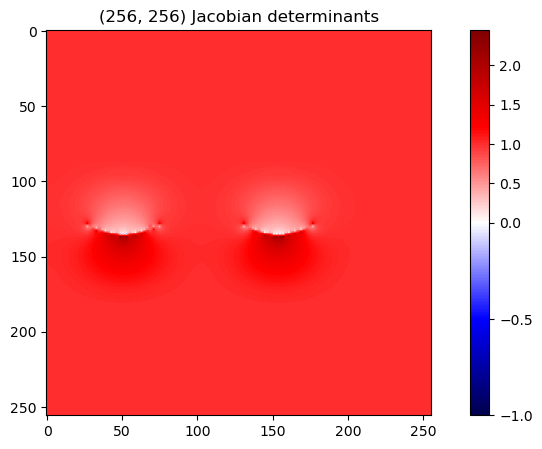

Minimum Jacobian determinant: -0.17
Number of negative Jacobian determinants: 10

=== Resolution / 3 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 69 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.80, Std: 4.88, Max: 16.00


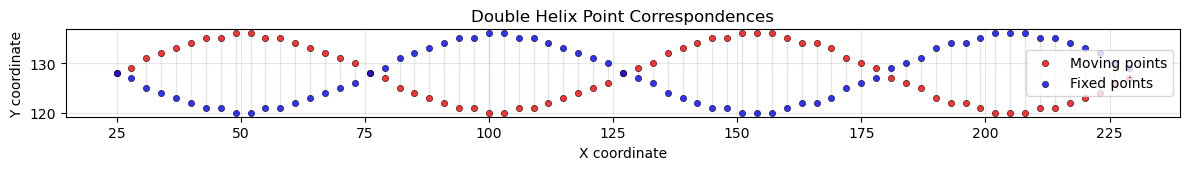

Analyzing 69 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 33 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.242, X=0.000
  Std displacement:  Z=0.000, Y=4.506, X=0.000
Cluster 1: 36 points (indices: [0, 17, 18, 19, 20]...)
  Mean displacement: Z=0.000, Y=9.389, X=0.000
  Std displacement:  Z=0.000, Y=5.160, X=0.000


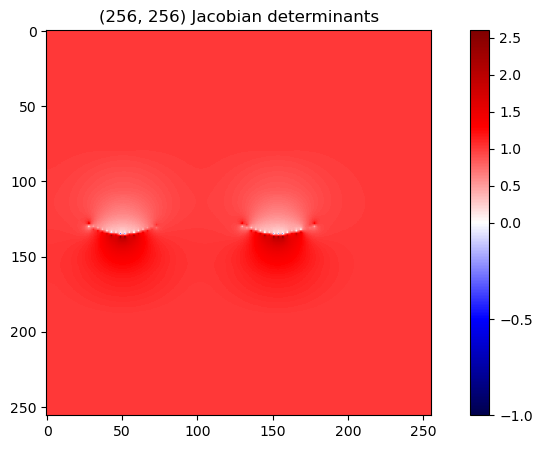

Minimum Jacobian determinant: -0.34
Number of negative Jacobian determinants: 10

=== Resolution / 4 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 52 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.69, Std: 4.91, Max: 16.00


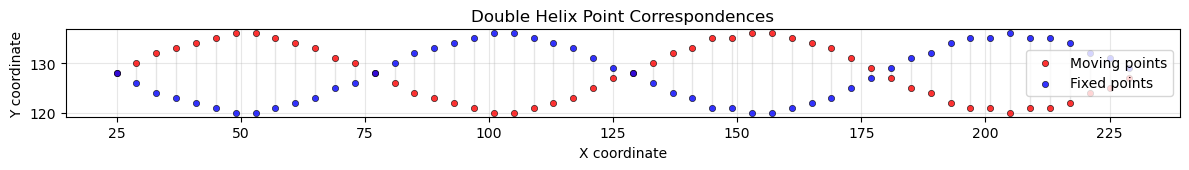

Analyzing 52 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 24 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.500, X=0.000
  Std displacement:  Z=0.000, Y=4.291, X=0.000
Cluster 1: 28 points (indices: [0, 13, 14, 15, 16]...)
  Mean displacement: Z=0.000, Y=9.000, X=0.000
  Std displacement:  Z=0.000, Y=5.278, X=0.000


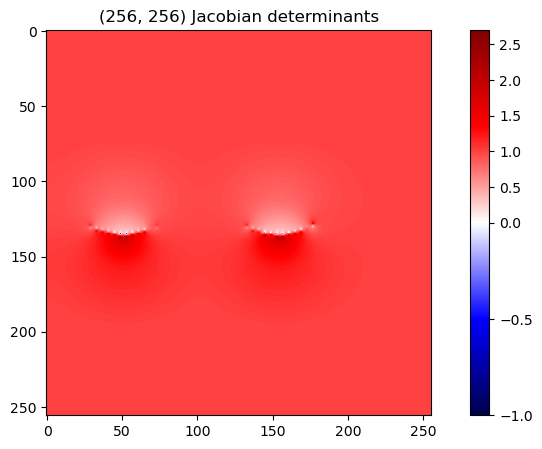

Minimum Jacobian determinant: -0.49
Number of negative Jacobian determinants: 9

=== Resolution / 5 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 42 point correspondences
Set 1 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.57, Std: 4.93, Max: 16.00


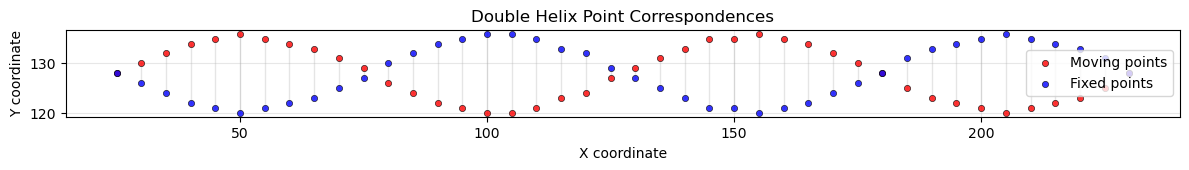

Analyzing 42 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 20 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-9.900, X=0.000
  Std displacement:  Z=0.000, Y=4.493, X=0.000
Cluster 1: 22 points (indices: [0, 11, 12, 13, 14]...)
  Mean displacement: Z=0.000, Y=9.273, X=0.000
  Std displacement:  Z=0.000, Y=5.276, X=0.000


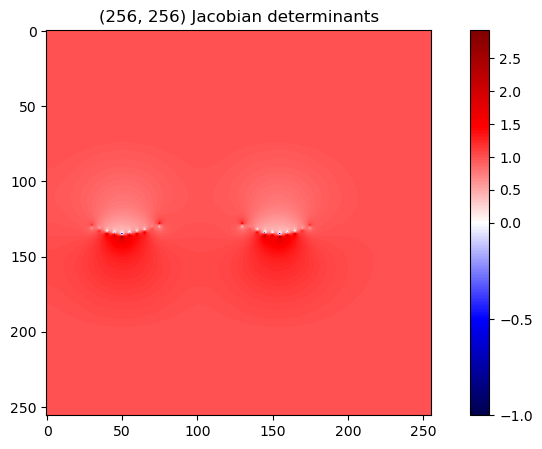

Minimum Jacobian determinant: -0.70
Number of negative Jacobian determinants: 9

=== Resolution / 6 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 35 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.66, Std: 4.98, Max: 16.00


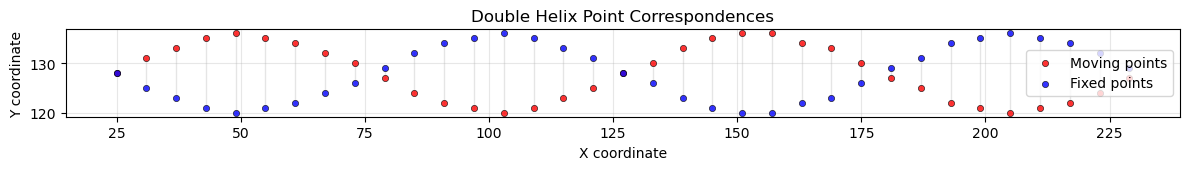

Analyzing 35 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 16 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.625, X=0.000
  Std displacement:  Z=0.000, Y=4.226, X=0.000
Cluster 1: 19 points (indices: [0, 9, 10, 11, 12]...)
  Mean displacement: Z=0.000, Y=8.842, X=0.000
  Std displacement:  Z=0.000, Y=5.402, X=0.000


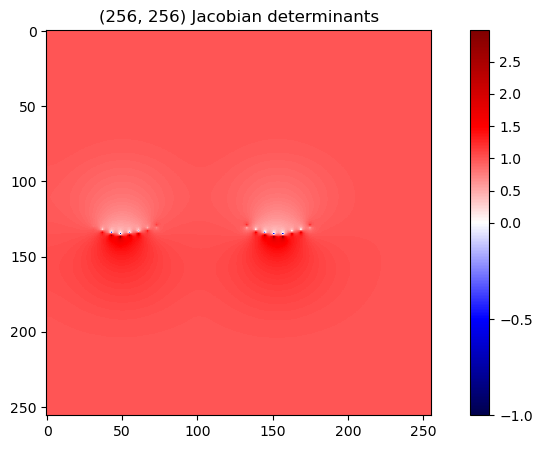

Minimum Jacobian determinant: -0.81
Number of negative Jacobian determinants: 8

=== Resolution / 7 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 30 point correspondences
Set 1 - X range: [25.0, 228.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 228.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.47, Std: 5.08, Max: 16.00


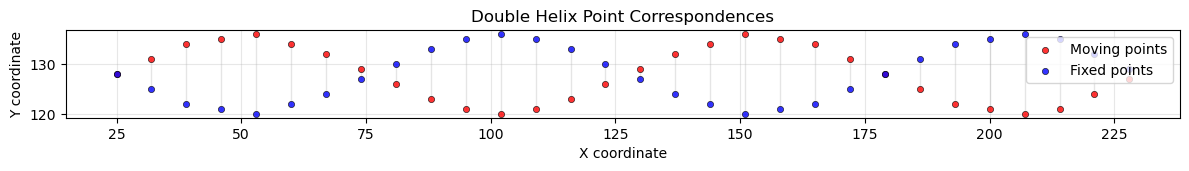

Analyzing 30 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 14 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.000, X=0.000
  Std displacement:  Z=0.000, Y=4.536, X=0.000
Cluster 1: 16 points (indices: [0, 8, 9, 10, 11]...)
  Mean displacement: Z=0.000, Y=9.000, X=0.000
  Std displacement:  Z=0.000, Y=5.477, X=0.000


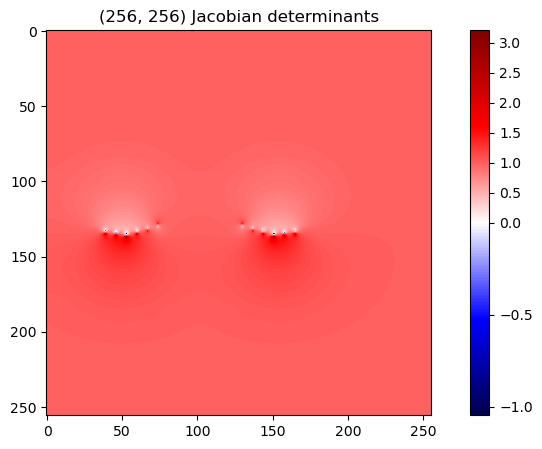

Minimum Jacobian determinant: -1.05
Number of negative Jacobian determinants: 10

=== Resolution / 8 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 26 point correspondences
Set 1 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.77, Std: 4.85, Max: 16.00


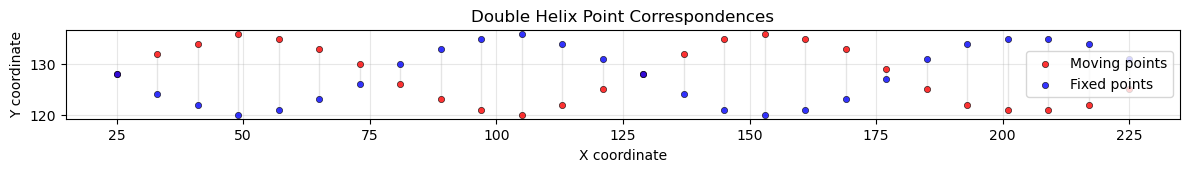

Analyzing 26 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 12 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.667, X=0.000
  Std displacement:  Z=0.000, Y=4.346, X=0.000
Cluster 1: 14 points (indices: [0, 7, 8, 9, 10]...)
  Mean displacement: Z=0.000, Y=9.000, X=0.000
  Std displacement:  Z=0.000, Y=5.113, X=0.000


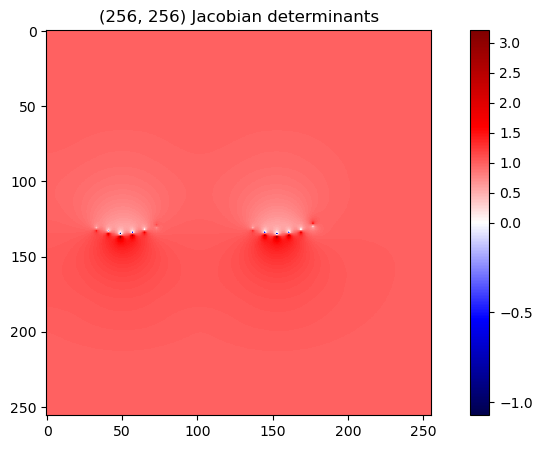

Minimum Jacobian determinant: -1.07
Number of negative Jacobian determinants: 10

=== Resolution / 9 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 23 point correspondences
Set 1 - X range: [25.0, 223.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 223.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.74, Std: 4.84, Max: 16.00


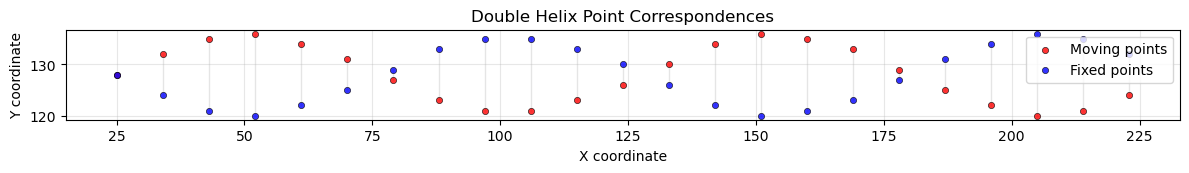

Analyzing 23 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 11 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.364, X=0.000
  Std displacement:  Z=0.000, Y=4.578, X=0.000
Cluster 1: 12 points (indices: [0, 6, 7, 8, 9]...)
  Mean displacement: Z=0.000, Y=9.167, X=0.000
  Std displacement:  Z=0.000, Y=4.997, X=0.000


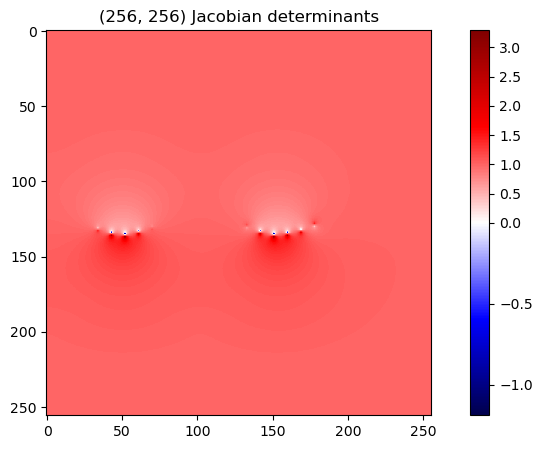

Minimum Jacobian determinant: -1.19
Number of negative Jacobian determinants: 9

=== Resolution / 10 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 21 point correspondences
Set 1 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.62, Std: 4.88, Max: 16.00


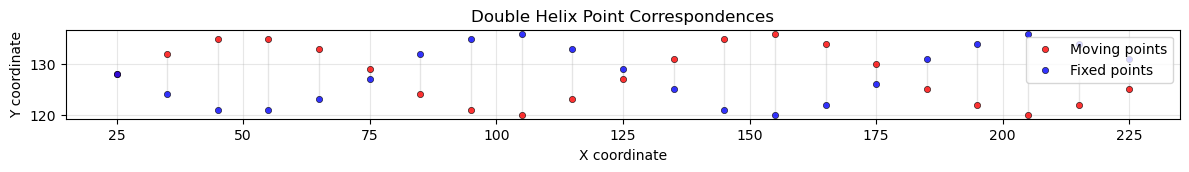

Analyzing 21 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 10 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.000, X=0.000
  Std displacement:  Z=0.000, Y=4.561, X=0.000
Cluster 1: 11 points (indices: [0, 6, 7, 8, 9]...)
  Mean displacement: Z=0.000, Y=9.273, X=0.000
  Std displacement:  Z=0.000, Y=5.136, X=0.000


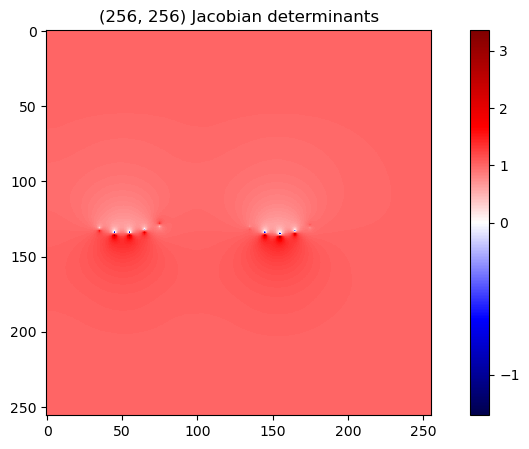

Minimum Jacobian determinant: -1.27
Number of negative Jacobian determinants: 9


In [11]:
# Create a specific double helix for correspondence analysis
print("\n=== Creating Double Helix for Point Correspondence ===")

resolution = (256, 256)  # Example resolution for the data
points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

#####################################################################################################

for num_points_skip in points_to_skip:
    print(f"\n=== Resolution / {num_points_skip} ===")

    helix_wave1, helix_wave2, _ = cluster.create_double_helix_waves(
        grid_size=256,
        num_cycles=2,
        amplitude_ratio=0.03,
        phase_offset=np.pi,  # 180 degrees for maximum separation
        padding_ratio=0.1,
        plot=False
    )

    # Decrease point density for better visualization
    helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
    helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

    # Plot the correspondences between the two helical waves
    cluster.plot_point_correspondences(helix_wave1, helix_wave2,
                            labels=('Moving points', 'Fixed points'),
                            colors=('red', 'blue'),
                            title='Double Helix Point Correspondences',
                            show_indices=False,
                            line_alpha=0.2,  # More transparent lines to show the pattern better
                            point_size=20)

    # Swap columns to match expected format (x, y)
    helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
    helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

    # Add 0s on the first axis to format for Data class
    helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
    helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

    #print(f"Analyzing {len(original_moving_points)} point correspondences from double helix")
    cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2)

    # Run Laplacian
    d = Data(helix_wave1[cluster_indices[0]], helix_wave2[cluster_indices[0]], resolution)
    d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False)
    print(f"Minimum Jacobian determinant: {d.min():.2f}")
    print(f"Number of negative Jacobian determinants: {d.count_negatives()}")

## Upwards cluster


=== Creating Double Helix for Point Correspondence ===

=== Resolution / 1 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 206 point correspondences
Set 1 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.79, Std: 4.83, Max: 16.00


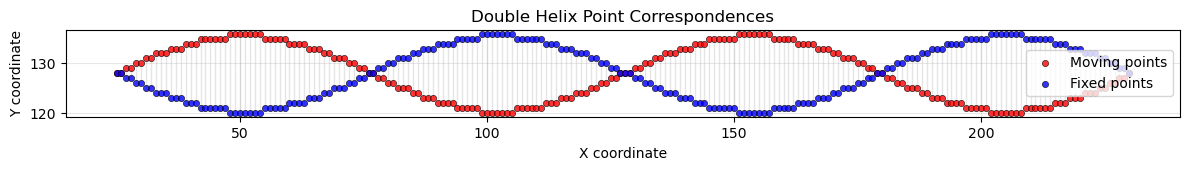

Analyzing 206 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 98 points (indices: [2, 3, 4, 5, 6]...)
  Mean displacement: Z=0.000, Y=-10.286, X=0.000
  Std displacement:  Z=0.000, Y=4.408, X=0.000
Cluster 1: 108 points (indices: [0, 1, 51, 52, 53]...)
  Mean displacement: Z=0.000, Y=9.333, X=0.000
  Std displacement:  Z=0.000, Y=5.150, X=0.000


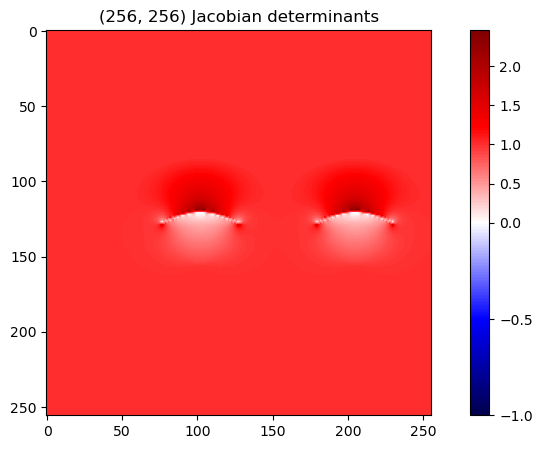

Minimum Jacobian determinant: -0.17
Number of negative Jacobian determinants: 22

=== Resolution / 2 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 103 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.79, Std: 4.83, Max: 16.00


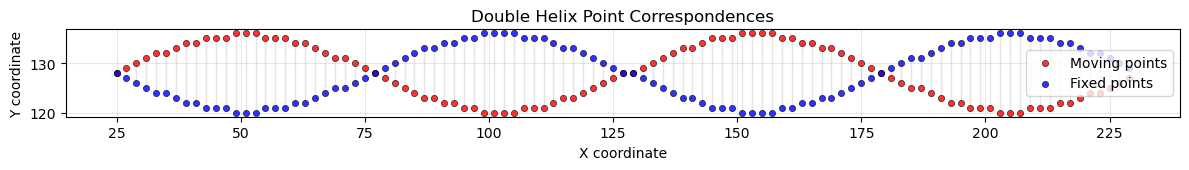

Analyzing 103 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 49 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.286, X=0.000
  Std displacement:  Z=0.000, Y=4.408, X=0.000
Cluster 1: 54 points (indices: [0, 26, 27, 28, 29]...)
  Mean displacement: Z=0.000, Y=9.333, X=0.000
  Std displacement:  Z=0.000, Y=5.150, X=0.000


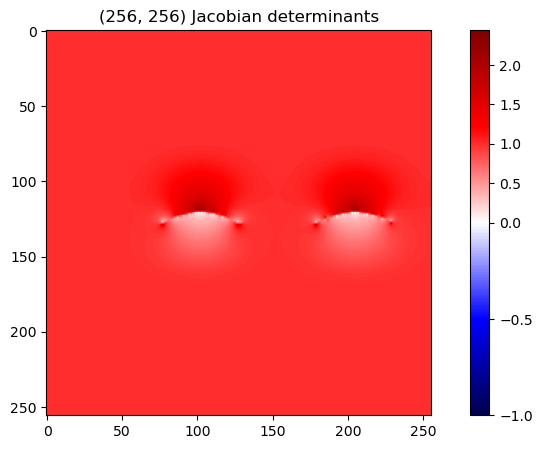

Minimum Jacobian determinant: -0.17
Number of negative Jacobian determinants: 10

=== Resolution / 3 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 69 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.80, Std: 4.88, Max: 16.00


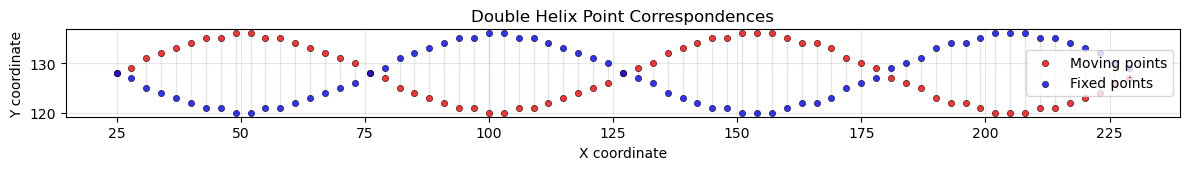

Analyzing 69 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 33 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.242, X=0.000
  Std displacement:  Z=0.000, Y=4.506, X=0.000
Cluster 1: 36 points (indices: [0, 17, 18, 19, 20]...)
  Mean displacement: Z=0.000, Y=9.389, X=0.000
  Std displacement:  Z=0.000, Y=5.160, X=0.000


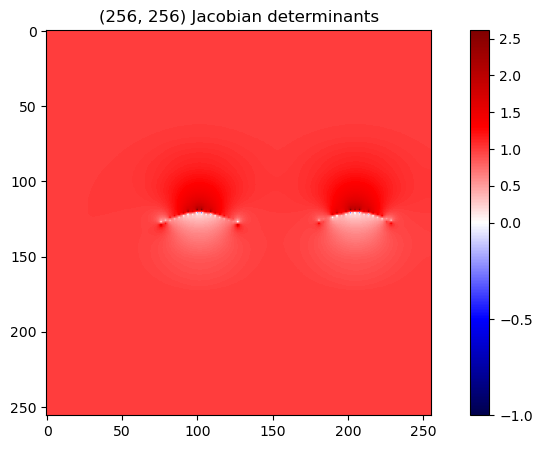

Minimum Jacobian determinant: -0.35
Number of negative Jacobian determinants: 11

=== Resolution / 4 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 52 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.69, Std: 4.91, Max: 16.00


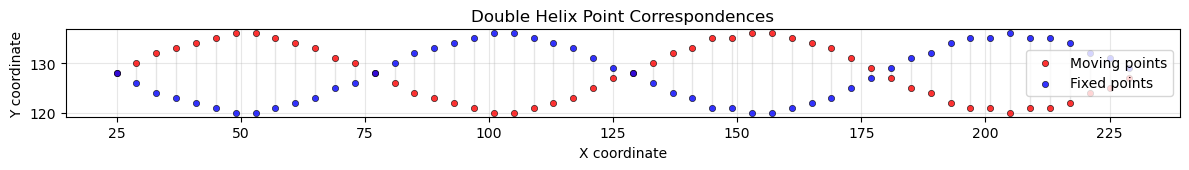

Analyzing 52 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 24 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.500, X=0.000
  Std displacement:  Z=0.000, Y=4.291, X=0.000
Cluster 1: 28 points (indices: [0, 13, 14, 15, 16]...)
  Mean displacement: Z=0.000, Y=9.000, X=0.000
  Std displacement:  Z=0.000, Y=5.278, X=0.000


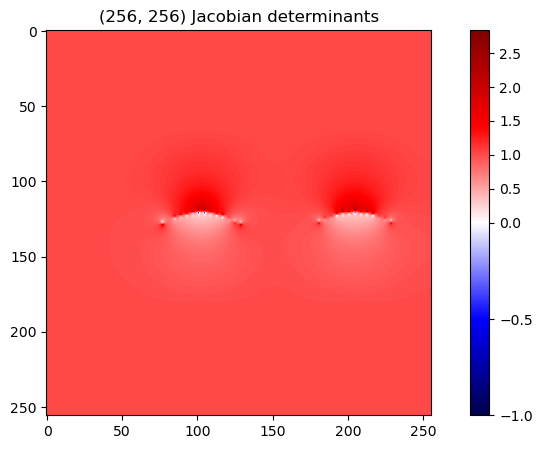

Minimum Jacobian determinant: -0.56
Number of negative Jacobian determinants: 14

=== Resolution / 5 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 42 point correspondences
Set 1 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.57, Std: 4.93, Max: 16.00


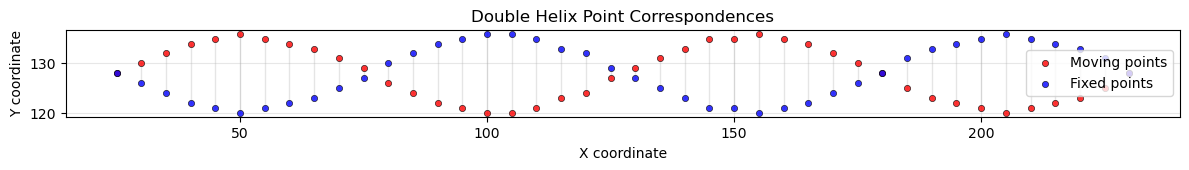

Analyzing 42 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 20 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-9.900, X=0.000
  Std displacement:  Z=0.000, Y=4.493, X=0.000
Cluster 1: 22 points (indices: [0, 11, 12, 13, 14]...)
  Mean displacement: Z=0.000, Y=9.273, X=0.000
  Std displacement:  Z=0.000, Y=5.276, X=0.000


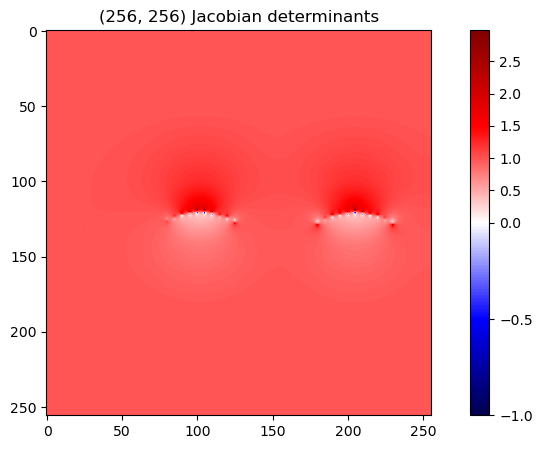

Minimum Jacobian determinant: -0.75
Number of negative Jacobian determinants: 14

=== Resolution / 6 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 35 point correspondences
Set 1 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 229.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.66, Std: 4.98, Max: 16.00


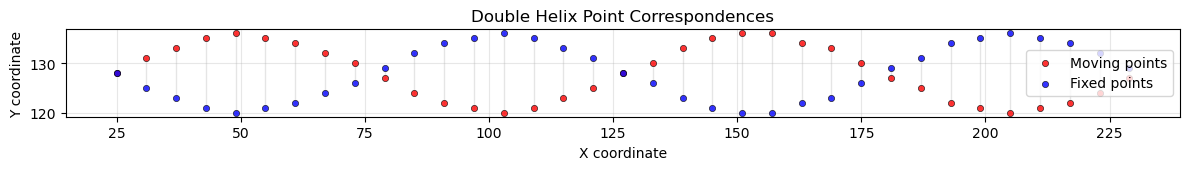

Analyzing 35 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 16 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.625, X=0.000
  Std displacement:  Z=0.000, Y=4.226, X=0.000
Cluster 1: 19 points (indices: [0, 9, 10, 11, 12]...)
  Mean displacement: Z=0.000, Y=8.842, X=0.000
  Std displacement:  Z=0.000, Y=5.402, X=0.000


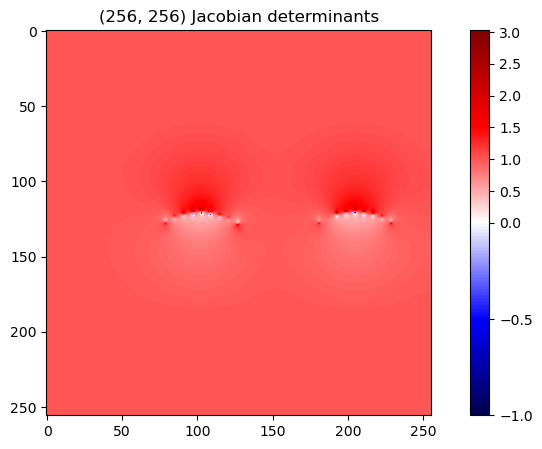

Minimum Jacobian determinant: -0.85
Number of negative Jacobian determinants: 10

=== Resolution / 7 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 30 point correspondences
Set 1 - X range: [25.0, 228.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 228.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.47, Std: 5.08, Max: 16.00


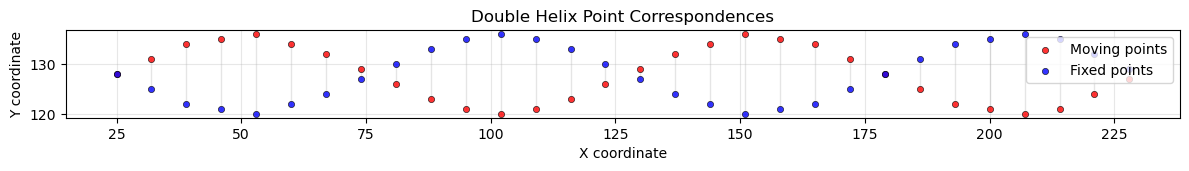

Analyzing 30 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 14 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.000, X=0.000
  Std displacement:  Z=0.000, Y=4.536, X=0.000
Cluster 1: 16 points (indices: [0, 8, 9, 10, 11]...)
  Mean displacement: Z=0.000, Y=9.000, X=0.000
  Std displacement:  Z=0.000, Y=5.477, X=0.000


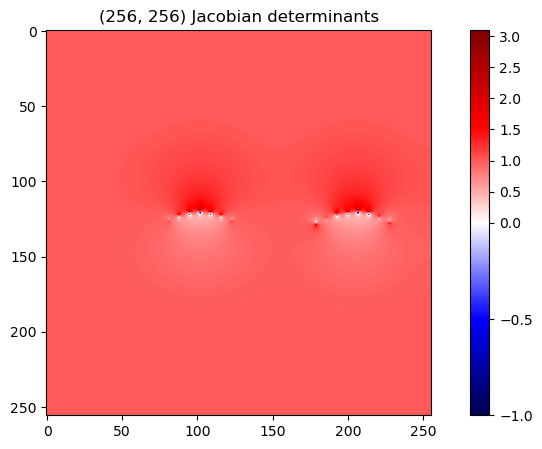

Minimum Jacobian determinant: -0.96
Number of negative Jacobian determinants: 12

=== Resolution / 8 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 26 point correspondences
Set 1 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.77, Std: 4.85, Max: 16.00


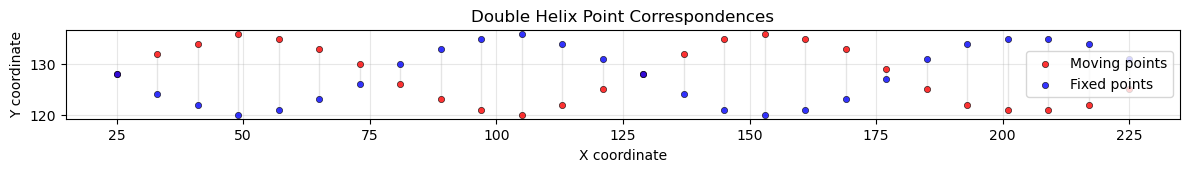

Analyzing 26 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 12 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.667, X=0.000
  Std displacement:  Z=0.000, Y=4.346, X=0.000
Cluster 1: 14 points (indices: [0, 7, 8, 9, 10]...)
  Mean displacement: Z=0.000, Y=9.000, X=0.000
  Std displacement:  Z=0.000, Y=5.113, X=0.000


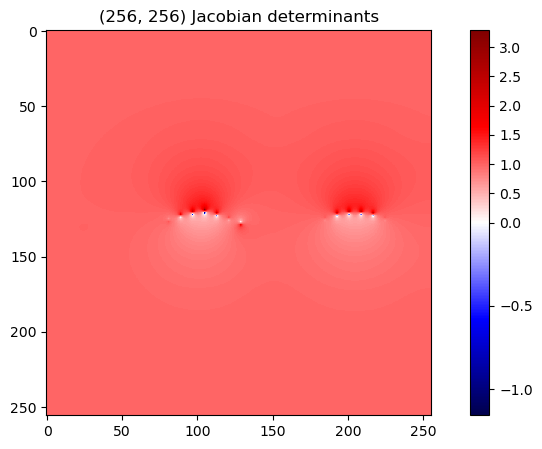

Minimum Jacobian determinant: -1.16
Number of negative Jacobian determinants: 9

=== Resolution / 9 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 23 point correspondences
Set 1 - X range: [25.0, 223.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 223.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.74, Std: 4.84, Max: 16.00


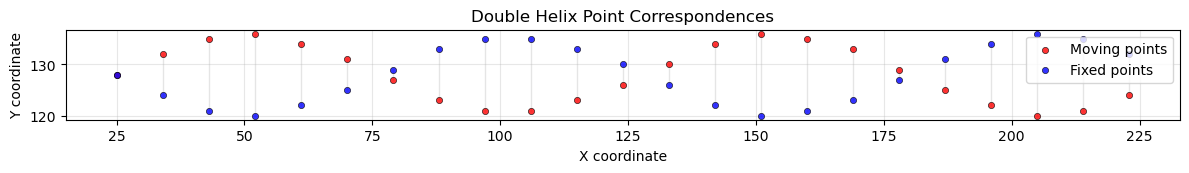

Analyzing 23 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 11 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.364, X=0.000
  Std displacement:  Z=0.000, Y=4.578, X=0.000
Cluster 1: 12 points (indices: [0, 6, 7, 8, 9]...)
  Mean displacement: Z=0.000, Y=9.167, X=0.000
  Std displacement:  Z=0.000, Y=4.997, X=0.000


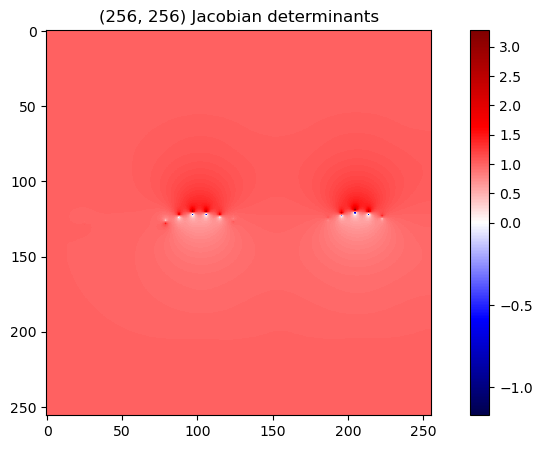

Minimum Jacobian determinant: -1.17
Number of negative Jacobian determinants: 8

=== Resolution / 10 ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 21 point correspondences
Set 1 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 225.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.62, Std: 4.88, Max: 16.00


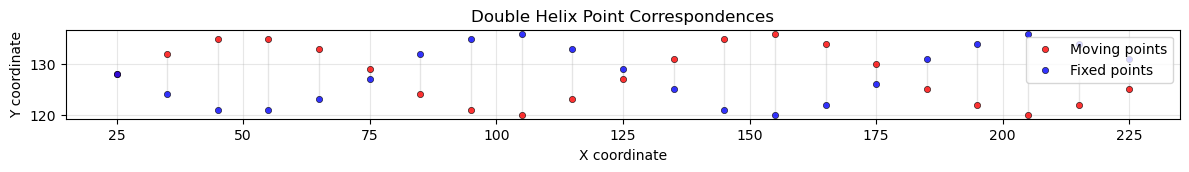

Analyzing 21 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 10 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=-10.000, X=0.000
  Std displacement:  Z=0.000, Y=4.561, X=0.000
Cluster 1: 11 points (indices: [0, 6, 7, 8, 9]...)
  Mean displacement: Z=0.000, Y=9.273, X=0.000
  Std displacement:  Z=0.000, Y=5.136, X=0.000


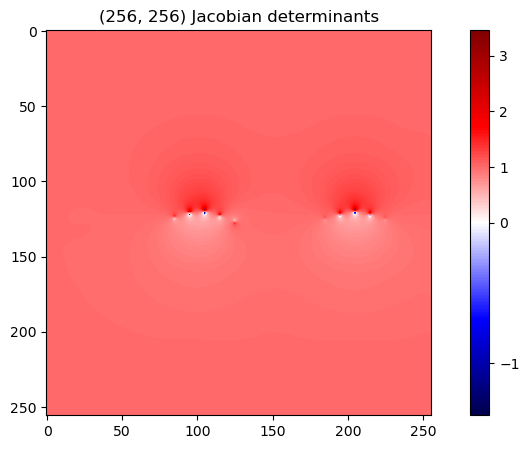

Minimum Jacobian determinant: -1.37
Number of negative Jacobian determinants: 8


In [12]:
# Create a specific double helix for correspondence analysis
print("\n=== Creating Double Helix for Point Correspondence ===")

resolution = (256, 256)  # Example resolution for the data
points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

#####################################################################################################

for num_points_skip in points_to_skip:
    print(f"\n=== Resolution / {num_points_skip} ===")

    helix_wave1, helix_wave2, _ = cluster.create_double_helix_waves(
        grid_size=256,
        num_cycles=2,
        amplitude_ratio=0.03,
        phase_offset=np.pi,  # 180 degrees for maximum separation
        padding_ratio=0.1,
        plot=False
    )

    # Decrease point density for better visualization
    helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
    helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

    # Plot the correspondences between the two helical waves
    cluster.plot_point_correspondences(helix_wave1, helix_wave2,
                            labels=('Moving points', 'Fixed points'),
                            colors=('red', 'blue'),
                            title='Double Helix Point Correspondences',
                            show_indices=False,
                            line_alpha=0.2,  # More transparent lines to show the pattern better
                            point_size=20)

    # Swap columns to match expected format (x, y)
    helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
    helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

    # Add 0s on the first axis to format for Data class
    helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
    helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

    #print(f"Analyzing {len(original_moving_points)} point correspondences from double helix")
    cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2)

    # Run Laplacian
    d = Data(helix_wave1[cluster_indices[1]], helix_wave2[cluster_indices[1]], resolution)
    d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False)
    print(f"Minimum Jacobian determinant: {d.min():.2f}")
    print(f"Number of negative Jacobian determinants: {d.count_negatives()}")

# Create double helix for clustering correspondence

In [13]:
def draw_points_to_image(points, resolution=(256, 256), filename=None):
    """
    Simple function that takes points, creates a raw image with sequential connections,
    and saves it to a file.
    
    Parameters:
    -----------
    points : numpy.ndarray
        Array of points, shape (N, 3) with (z, y, x) coordinates
    resolution : tuple, default=(256, 256)
        Image resolution (height, width)
    filename : str, optional
        Filename to save the image. If None, uses timestamp
        
    Returns:
    --------
    image : numpy.ndarray
        The generated image array with white background and black lines
    saved_filename : str
        The filename where the image was saved
    """
    from skimage import draw
    from datetime import datetime
    
    height, width = resolution
    
    # Create white background image
    image = np.full((height, width), 255, dtype=np.uint8)
    
    # Connect points sequentially: 0→1, 1→2, 2→3, etc.
    for i in range(len(points) - 1):
        # Get consecutive points (y, x coordinates for image indexing)
        start_y, start_x = int(points[i, 1]), int(points[i, 2])
        end_y, end_x = int(points[i + 1, 1]), int(points[i + 1, 2])
        
        # Ensure points are within image bounds
        if (0 <= start_x < width and 0 <= start_y < height and
            0 <= end_x < width and 0 <= end_y < height):
            
            # Draw line using Bresenham's algorithm
            rr, cc = draw.line(start_y, start_x, end_y, end_x)
            # Clip to image bounds
            valid_pixels = (rr >= 0) & (rr < height) & (cc >= 0) & (cc < width)
            rr, cc = rr[valid_pixels], cc[valid_pixels]
            image[rr, cc] = 0  # Black lines
    
    # Generate filename if not provided
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"points_image_{timestamp}.png"
    elif not filename.lower().endswith('.png'):
        filename += '.png'
    
    # Save the raw image using matplotlib with exact resolution
    fig, ax = plt.subplots(figsize=(width/100, height/100), dpi=100)
    ax.imshow(image, cmap='gray', vmin=0, vmax=255, origin='upper', interpolation='nearest')
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)  # Flip Y axis to match image coordinates
    ax.axis('off')  # No axes
    
    # Remove all padding and margins for raw output
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.margins(0)
    
    # Save with exact resolution - raw image
    plt.savefig(filename, bbox_inches='tight', pad_inches=0, dpi=100, 
                facecolor='white', edgecolor='none')
    plt.close()
    
    return image, filename



# Test the updated function
#print("✓ Updated function: draw_points_to_image(points, resolution, filename)")
#print("  - Returns: (image_array, saved_filename)")
#print("  - Saves raw PNG file with exact resolution")

# Test with existing data
#if 'downward_moving' in globals():
#    print(f"\nTesting with downward_moving: {downward_moving.shape}")
#    test_image, saved_file = draw_points_to_image(downward_moving, (256, 256), "test_downward")
#    print(f"✓ Image saved as: {saved_file}")
#    print(f"✓ Image array: {test_image.shape}, values {test_image.min()}-{test_image.max()}")
#else:
#    print("\nNo test data available")

def draw_points_to_image(points, resolution=(256, 256), filename=None):
    """
    Simple function that takes points and creates a raw image with 1-pixel points,
    and saves it to a file.

    Parameters:
    -----------
    points : numpy.ndarray
        Array of points, shape (N, 3) with (z, y, x) coordinates
    resolution : tuple, default=(256, 256)
        Image resolution (height, width)
    filename : str, optional
        Filename to save the image. If None, uses timestamp

    Returns:
    --------
    image : numpy.ndarray
        The generated image array with white background and black points
    saved_filename : str
        The filename where the image was saved
    """
    from datetime import datetime

    height, width = resolution

    # Create white background image
    image = np.full((height, width), 255, dtype=np.uint8)

    # Draw each point as a single black pixel
    for i in range(len(points)):
        y, x = int(points[i, 1]), int(points[i, 2])
        if 0 <= x < width and 0 <= y < height:
            image[y, x] = 0  # Black pixel

    # Generate filename if not provided
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"points_image_{timestamp}.png"
    elif not filename.lower().endswith('.png'):
        filename += '.png'

    # Save the raw image using matplotlib with exact resolution
    fig, ax = plt.subplots(figsize=(width/100, height/100), dpi=100)
    ax.imshow(image, cmap='gray', vmin=0, vmax=255, origin='upper', interpolation='nearest')
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)  # Flip Y axis to match image coordinates
    ax.axis('off')  # No axes

    # Remove all padding and margins for raw output
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.margins(0)

    # Save with exact resolution - raw image
    plt.savefig(filename, bbox_inches='tight', pad_inches=0, dpi=100,
                facecolor='white', edgecolor='none')
    plt.close()

    return image, filename

## Setup tests

In [ ]:
def apply_transformation_forward_splat(d, moving_image, mpoints=None, fpoints=None, title="Transformed image"):
    """
    Forward mapping for binary images: splat black wherever any black pixel lands.
    """
    deformation_field = d.deformation  # (channels, batch, y, x)
    H, W = moving_image.shape
    out_img = np.ones_like(moving_image, dtype=np.float32)  # Start with all white

    for y in range(H):
        for x in range(W):
            val = moving_image[y, x]
            if val > 0.5:
                continue  # Only splat black pixels

            dy = deformation_field[1, 0, y, x]
            dx = deformation_field[2, 0, y, x]
            new_y = y + dy
            new_x = x + dx

            # Bilinear splat to output image
            if 0 <= new_y < H-1 and 0 <= new_x < W-1:
                y0 = int(np.floor(new_y))
                x0 = int(np.floor(new_x))
                
                y0 = int(np.round(new_y))
                x0 = int(np.round(new_x))
                
                y1 = y0 + 1
                x1 = x0 + 1
                wy = new_y - y0
                wx = new_x - x0
                # Splat black (0) using min (so any hit makes it black)
                if 0 <= y0 < H and 0 <= x0 < W:
                    out_img[y0, x0] = min(out_img[y0, x0], 0)
                if 0 <= y0 < H and 0 <= x1 < W:
                    out_img[y0, x1] = min(out_img[y0, x1], 0)
                if 0 <= y1 < H and 0 <= x0 < W:
                    out_img[y1, x0] = min(out_img[y1, x0], 0)
                if 0 <= y1 < H and 0 <= x1 < W:
                    out_img[y1, x1] = min(out_img[y1, x1], 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(out_img, cmap='gray', vmin=0, vmax=1)
    if mpoints is not None and fpoints is not None:
        for i in range(mpoints.shape[0]):
            plt.scatter(mpoints[i, 2], mpoints[i, 1], color='red', s=5, alpha=0.25)
            plt.scatter(fpoints[i, 2], fpoints[i, 1], color='green', s=5, alpha=0.1)
    plt.title(title)
    plt.legend(['Moving Points', 'Fixed Points'], loc='upper right')
    plt.show()
    return out_img


def apply_transformation_forward(d, moving_image, mpoints=None, fpoints=None, title="Transformed image"):
    """
    Forward mapping for binary images: splat black wherever any black pixel lands (nearest neighbor).
    """
    deformation_field = d.deformation  # (channels, batch, y, x)
    H, W = moving_image.shape
    out_img = np.ones_like(moving_image, dtype=np.float32)  # Start with all white

    for y in range(H):
        for x in range(W):
            val = moving_image[y, x]
            if val > 0.5:
                continue  # Only splat black pixels

            dy = deformation_field[1, 0, y, x]
            dx = deformation_field[2, 0, y, x]
            new_y = int(np.round(y + dy))
            new_x = int(np.round(x + dx))

            if 0 <= new_y < H and 0 <= new_x < W:
                out_img[new_y, new_x] = 0  # Paint black

    plt.figure(figsize=(10, 10))
    plt.imshow(out_img, cmap='gray', vmin=0, vmax=1)
    if mpoints is not None and fpoints is not None:
        for i in range(mpoints.shape[0]):
            plt.scatter(mpoints[i, 2], mpoints[i, 1], color='red', s=5, alpha=0.25)
            plt.scatter(fpoints[i, 2], fpoints[i, 1], color='green', s=5, alpha=0.1)
        plt.legend(['Moving Points', 'Fixed Points'], loc='upper right')
    plt.title(title)
    plt.show()
    return out_img


=== Creating Double Helix for Point Correspondence ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 206 point correspondences
Set 1 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.79, Std: 4.83, Max: 16.00


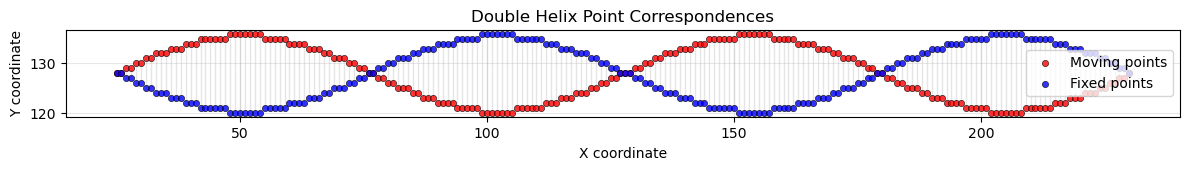

Analyzing 206 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 98 points (indices: [2, 3, 4, 5, 6]...)
  Mean displacement: Z=0.000, Y=-10.286, X=0.000
  Std displacement:  Z=0.000, Y=4.408, X=0.000
Cluster 1: 108 points (indices: [0, 1, 51, 52, 53]...)
  Mean displacement: Z=0.000, Y=9.333, X=0.000
  Std displacement:  Z=0.000, Y=5.150, X=0.000


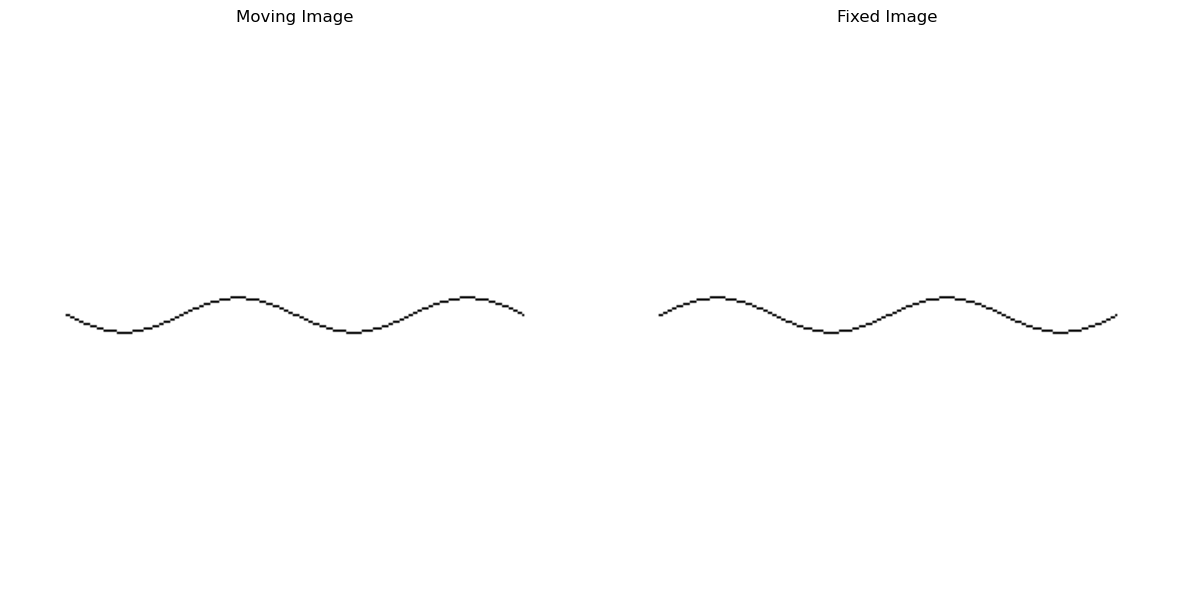

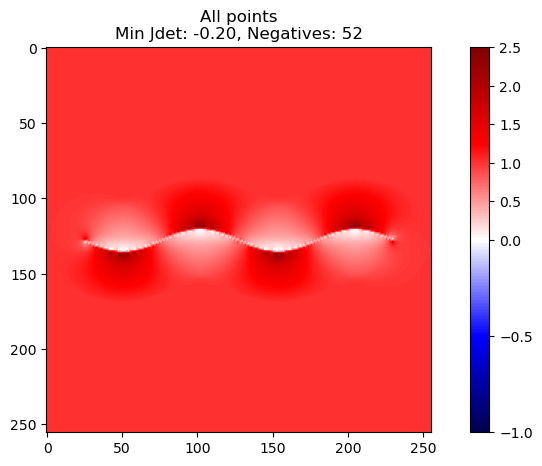

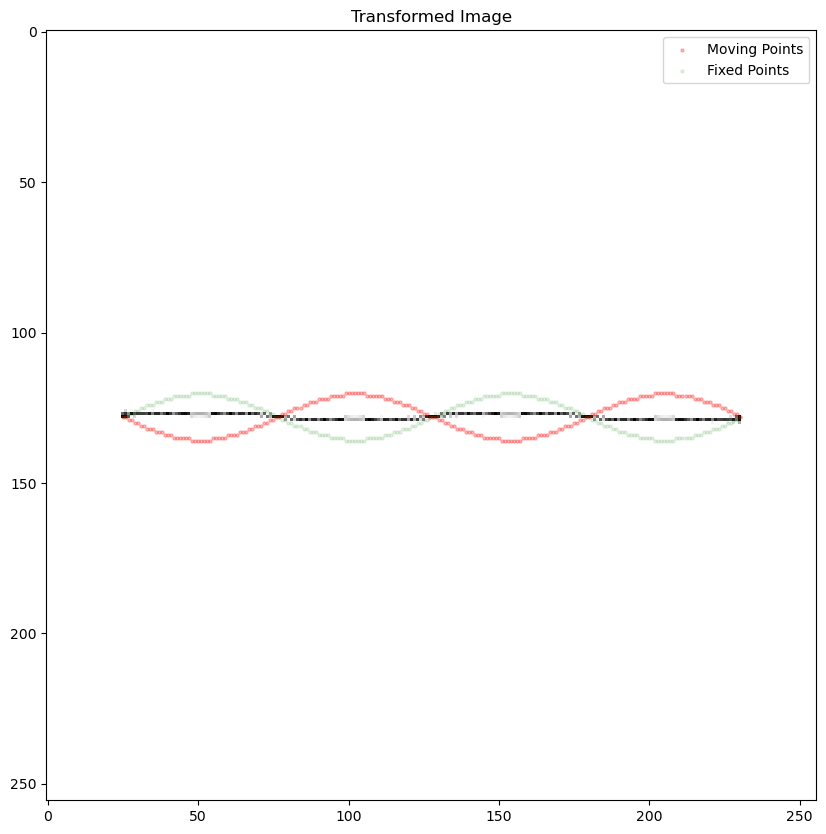

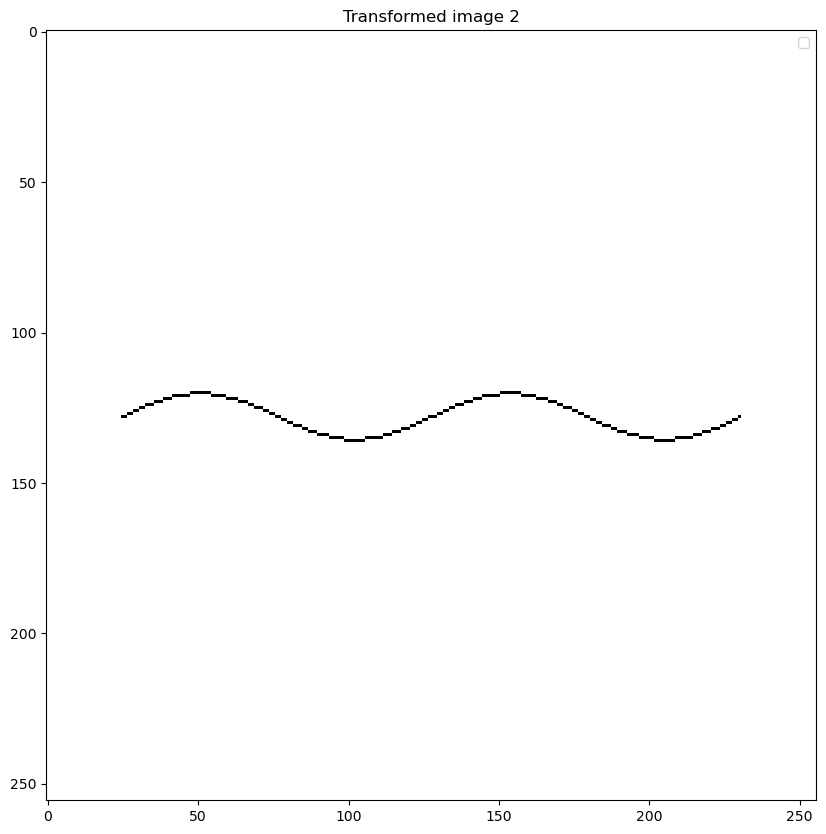

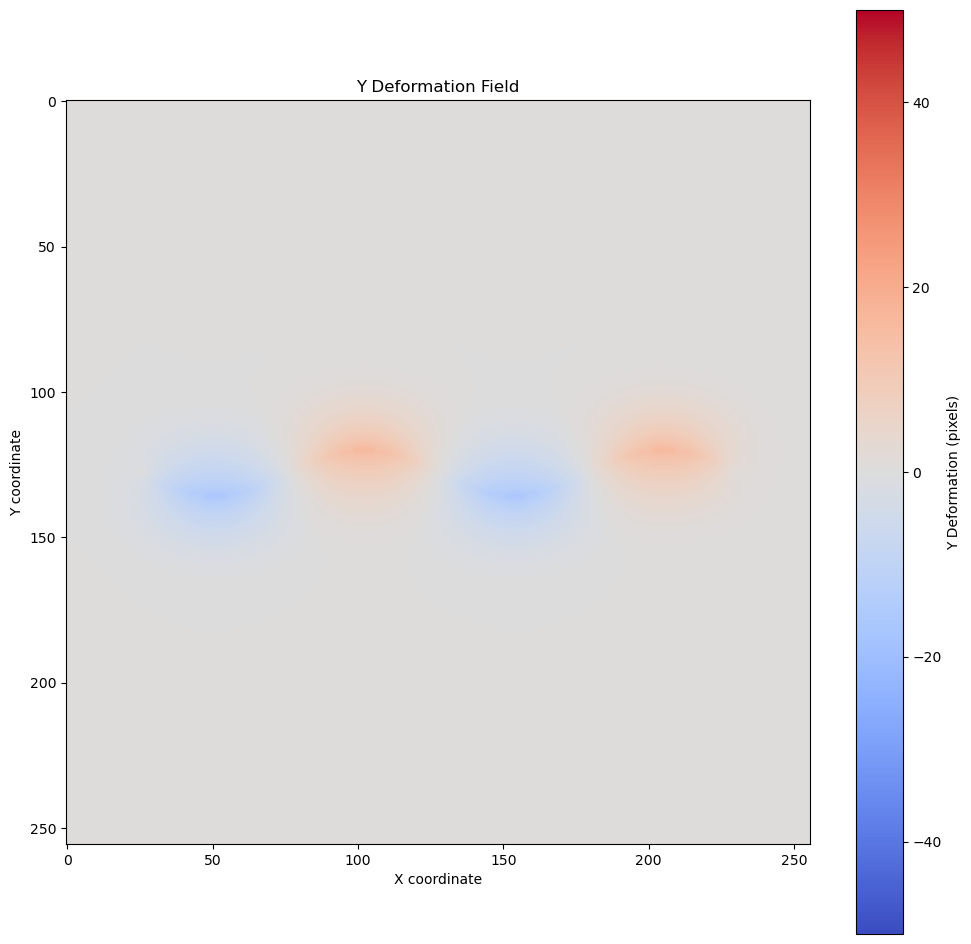

fdata.shape (1, 256, 256)
Time taken to create A:  0.0765233039855957
Total error: 1.51


In [52]:
# Create a specific double helix for correspondence analysis
print("\n=== Creating Double Helix for Point Correspondence ===")
helix_wave1, helix_wave2, _ = cluster.create_double_helix_waves(
    grid_size=256,
    num_cycles=2,
    amplitude_ratio=0.03,
    phase_offset=np.pi,  # 180 degrees for maximum separation
    padding_ratio=0.1,
    plot=False
)

#helix_wave1, helix_wave2, _ = create_double_helix_waves(grid_size=256, num_cycles=2, amplitude_ratio=0.03, 
#                           vertical_center_ratio=0.5, padding_ratio=0.1)

#helix_wave1, helix_wave2 = create_blobby_circular_shapes(n_points=100, plot=True, noise_scale=6)
#helix_wave1, helix_wave2 = create_ellipse_correspondences(n_points=80, plot=True)
#helix_wave1, helix_wave2 = create_crossing_lines_correspondences(n_points=80, plot=True)

resolution = (256, 256)  # Example resolution for the data
num_points_skip = 1  # Skip every 5th point for better visualization

#####################################################################################################

# Move helix_wave1 up 
#helix_wave1[:, 1] += -100  # Move wave 1 up by 20 pixels
#helix_wave2[:, 1] += 100  # Move wave 1 up by 20 pixels

# Decrease point density for better visualization
helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

# Plot the correspondences between the two helical waves
cluster.plot_point_correspondences(helix_wave1, helix_wave2,
                          labels=('Moving points', 'Fixed points'),
                          colors=('red', 'blue'),
                          title='Double Helix Point Correspondences',
                          show_indices=False,
                          line_alpha=0.2,  # More transparent lines to show the pattern better
                          point_size=20)

# Swap columns to match expected format (x, y)
helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

# Add 0s on the first axis to format for Data class
helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)



# Get the downards and upwards clusters
try:
    cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2, method='y_direction')
    down_indices = cluster_indices[0]
    up_indices = cluster_indices[1]
except:
    print("Error getting cluster indices. Ensure the points are in the correct format.")

# Save to raw image
test_image, saved_file = draw_points_to_image(helix_wave1, (256, 256), "wave1")
test_image2, saved_file2 = draw_points_to_image(helix_wave2, (256, 256), "wave2")
moving_img = load_png("wave1.png", scale=1.0, alpha=1.0)[:, :, 0]
fixed_img = load_png("wave2.png", scale=1.0, alpha=1.0)[:, :, 0]

# Manually create moving_img
moving_img = np.ones((256, 256), dtype=np.float32)
for i in range(len(helix_wave1)):
    y, x = helix_wave1[i, 1], helix_wave1[i, 2]
    moving_img[y, x] = 0
fixed_img = np.ones((256, 256), dtype=np.float32)
for i in range(len(helix_wave2)):
    y, x = helix_wave2[i, 1], helix_wave2[i, 2]
    fixed_img[y, x] = 0

show_2_pngs(moving_img, fixed_img, title1="Moving Image", title2="Fixed Image")

# Run Laplacian
d = Data(helix_wave1, helix_wave2, resolution)
d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
       title=f"All points\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")
d_original = deepcopy(d)



transformed_img = apply_transformation(d, moving_img,
                     mpoints=d.mpoints, 
                     fpoints=d.fpoints, 
                     title="Transformed Image")


apply_transformation_forward(d, moving_img, mpoints=None, fpoints=None, title="Transformed image 2")

# Make a heatmap of the deformation field
plt.figure(figsize=(12, 12))
plt.imshow(d.deformation[1, 0], cmap='coolwarm', vmin=-50, vmax=50)
plt.colorbar(label='Y Deformation (pixels)')
plt.title('Y Deformation Field')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

_, _, _, total_err = compute_error(d.resolution, helix_wave1, helix_wave2, d.deformation)
print(f"Total error: {total_err:.2f}")

In [42]:
print("moving pt:", helix_wave1[20])
print("fixed pt:",helix_wave2[20])
print(d.deformation[1, 0, 35, 45], d.deformation[2, 0, 35, 45])

moving pt: [  0 135  45]
fixed pt: [  0 121  45]
0.0 0.0


In [21]:
d.deformation[:, 0, 35, 45]

array([  0.        , 185.97947624,   0.        ])

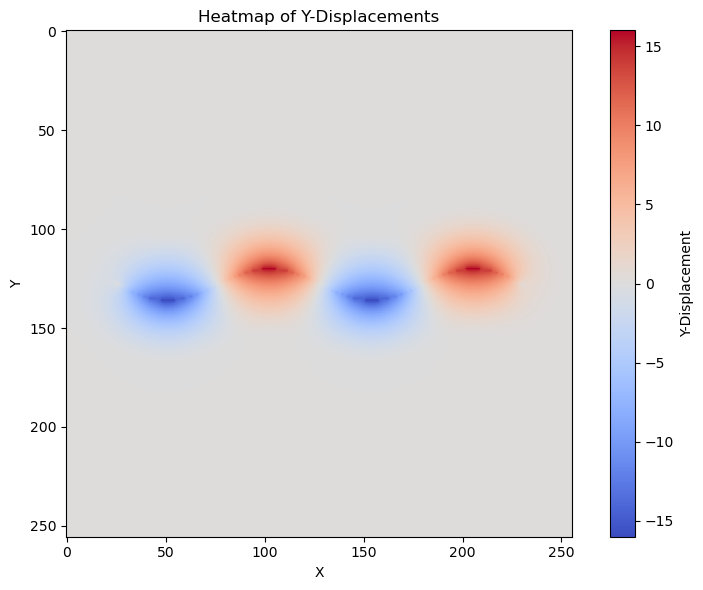

In [16]:
# Visualize the y-displacement field as a heatmap
plt.figure(figsize=(8, 6))
y_disp = d.deformation[1, 0, :, :]  # y-displacement field
plt.imshow(y_disp, cmap='coolwarm', origin='upper')
plt.colorbar(label='Y-Displacement')
plt.title('Heatmap of Y-Displacements')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

In [28]:
print(transformed_img[136, 100])
print(moving_img[120, 100]) #, fixed_img[136, 100]

0.0
0.0


In [29]:
np.max(d.deformation[2, 0, :, :])

0.0

In [30]:
print("Moving points:")
pprint(helix_wave1[up_indices][::2])
print("Fixed points:")
pprint(helix_wave2[up_indices][::2])

for i in range(len(up_indices)):
    moving_pt = helix_wave1[up_indices[i]]
    fixed_pt = helix_wave2[up_indices[i]]
    y_displacement = d.deformation[1, 0, fixed_pt[1], fixed_pt[2]]
    print(f"Moving point {i}: {moving_pt}, Fixed point {i}: {fixed_pt}", "y-displacement:", y_displacement)

Moving points:
array([[  0, 128,  25],
       [  0, 128,  76],
       [  0, 127,  78],
       [  0, 126,  80],
       [  0, 125,  82],
       [  0, 125,  84],
       [  0, 124,  86],
       [  0, 123,  88],
       [  0, 122,  90],
       [  0, 122,  92],
       [  0, 121,  94],
       [  0, 121,  96],
       [  0, 121,  98],
       [  0, 120, 100],
       [  0, 120, 102],
       [  0, 120, 104],
       [  0, 121, 106],
       [  0, 121, 108],
       [  0, 121, 110],
       [  0, 122, 112],
       [  0, 122, 114],
       [  0, 123, 116],
       [  0, 124, 118],
       [  0, 124, 120],
       [  0, 125, 122],
       [  0, 126, 124],
       [  0, 127, 126],
       [  0, 128, 128],
       [  0, 128, 179],
       [  0, 127, 181],
       [  0, 126, 183],
       [  0, 125, 185],
       [  0, 125, 187],
       [  0, 124, 189],
       [  0, 123, 191],
       [  0, 122, 193],
       [  0, 122, 195],
       [  0, 121, 197],
       [  0, 121, 199],
       [  0, 121, 201],
       [  0, 120, 203],
 

In [55]:
print(f"Moving pt: {helix_wave1[up_indices][26]}, Fixed pt: {helix_wave2[up_indices][26]}")
print(f"Deformation at pt: {d.deformation[:, 0, 136, 100]}")
print(f"Deformation at pt: {d.deformation[:, 0, 135, 100]}")
print(f"Deformation at pt: {d.deformation[:, 0, 134, 100]}")

Moving pt: [  0 120 100], Fixed pt: [  0 136 100]
Deformation at pt: [  0.         -15.99641848   0.        ]
Deformation at pt: [  0.         -14.82115214   0.        ]
Deformation at pt: [  0.         -13.78407512   0.        ]


## Run on individual clusters

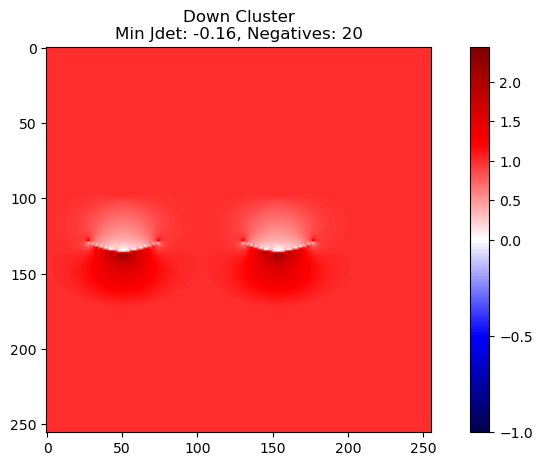

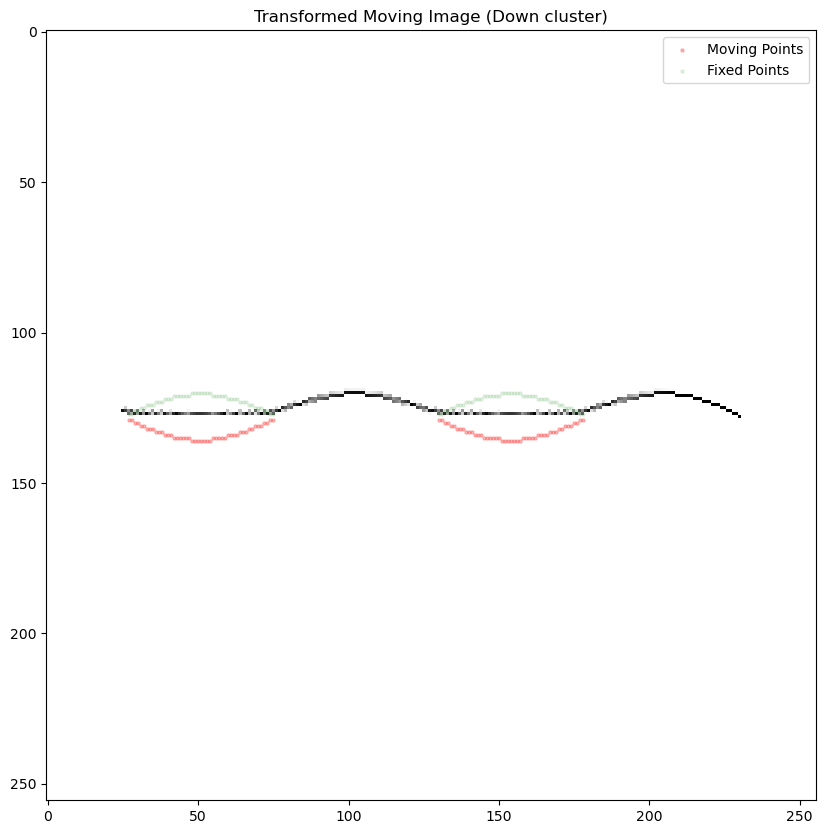

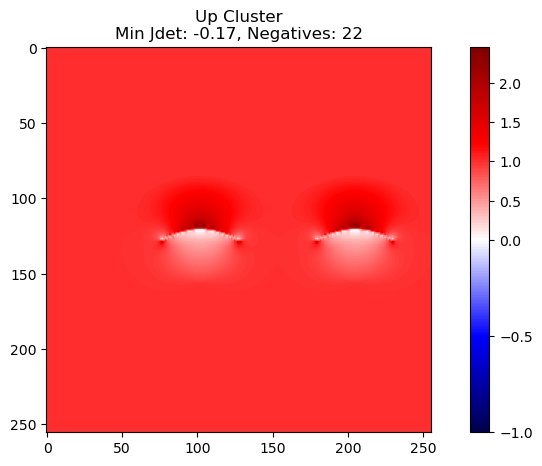

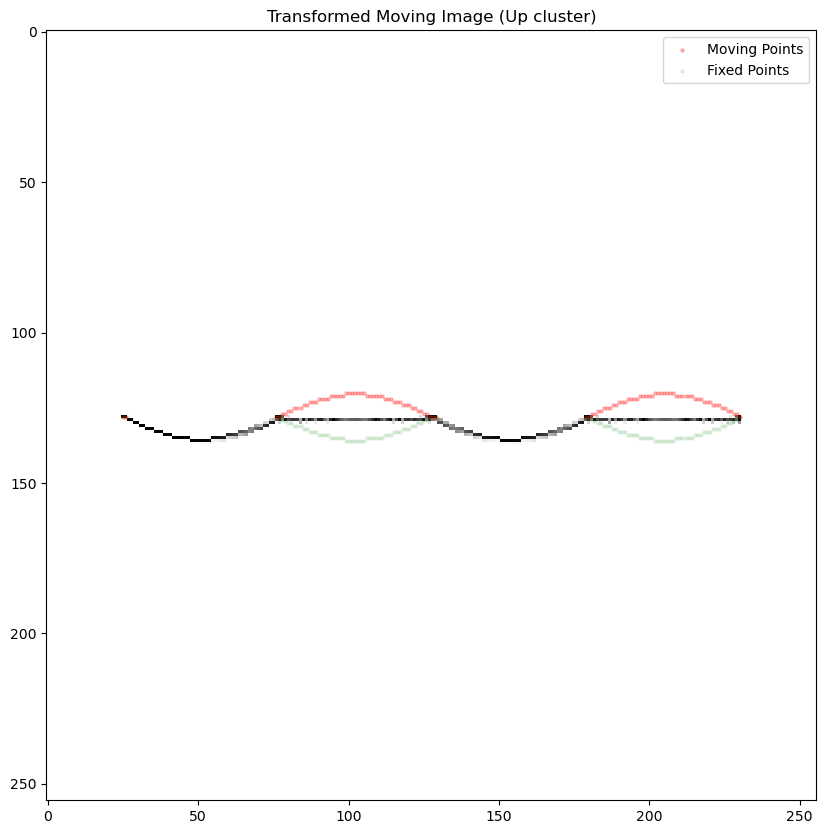

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [44]:
# Run Laplacian on down indices
d = Data(helix_wave1[down_indices], helix_wave2[down_indices], resolution)
d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, binarize_negatives=False,
          title="Down Cluster\nMin Jdet: {:.2f}, Negatives: {}".format(d.min(), d.count_negatives()))
apply_transformation(d, moving_img,
                     mpoints=d.mpoints, 
                     fpoints=d.fpoints, 
                     title="Transformed Moving Image (Down cluster)")

# Run Laplacian on up indices
d = Data(helix_wave1[up_indices], helix_wave2[up_indices], resolution)
d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, binarize_negatives=False,
          title=f"Up Cluster\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")
apply_transformation(d, moving_img,
                     mpoints=d.mpoints, 
                     fpoints=d.fpoints, 
                     title="Transformed Moving Image (Up cluster)")

## Laplacian clustering

In [ ]:
def cluster_laplacian(moving_points, fixed_points, resolution, clusters, moving_img=None, verbose=True):
    """
    Apply manual cluster-wise deformation as in the 'Down first' block.
    Args:
        moving_points: np.ndarray, shape (N, 3)
        fixed_points: np.ndarray, shape (N, 3)
        resolution: tuple, image resolution
        clusters: list of lists/arrays, each contains indices for a cluster
        moving_img: optional, image for visualization
        verbose: bool, show plots and info
    Returns:
        d_combined: Data object with combined deformation
    """
    # Step 1: First cluster deformation
    cluster1_idx = clusters[0]
    cluster2_idx = clusters[1]
    d1 = Data(moving_points[cluster1_idx], fixed_points[cluster1_idx], resolution)
    if verbose:
        d1.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                binarize_negatives=False, title=f"Cluster 1\nMin Jdet: {d1.min():.2f}, Negatives: {d1.count_negatives()}")
    if moving_img is not None:
        iter1 = apply_transformation(d1, moving_img, mpoints=moving_points, fpoints=fixed_points,
                                    title="Transformed Moving Image (Cluster 1)")
    else:
        iter1 = None

    # Step 2: Inverse deformation for cluster 1
    d1_inv = Data(fixed_points[cluster1_idx], moving_points[cluster1_idx], resolution)

    # Step 3: Fix cluster 1 points, move cluster 2 points
    new_mpoints = moving_points.copy()
    new_fpoints = fixed_points.copy()
    new_mpoints[cluster1_idx] = new_fpoints[cluster1_idx]  # Fix moving points to fixed points

    for idx in cluster2_idx:
        curr_mcoord = moving_points[idx]
        curr_fcoord = fixed_points[idx]
        new_mdisplacement = d1_inv.deformation[:, 0, curr_mcoord[1], curr_mcoord[2]]
        new_fdisplacement = d1_inv.deformation[:, 0, curr_fcoord[1], curr_fcoord[2]]
        # Optionally use new_fdisplacement, but original code uses new_mdisplacement for both
        new_mcoord = curr_mcoord + new_mdisplacement
        new_mcoord = np.round(new_mcoord).astype(int)
        #new_fcoord = curr_fcoord + new_mdisplacement
        new_fcoord = curr_fcoord + new_fdisplacement  # Use same displacement for fixed points
        new_fcoord = np.round(new_fcoord).astype(int)
        new_mpoints[idx] = new_mcoord
        new_fpoints[idx] = new_fcoord

    # Step 4: New Data object with updated points
    d2 = Data(new_mpoints, new_fpoints, resolution)
    if verbose:
        d2.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                binarize_negatives=False, title=f"Cluster 2\nMin Jdet: {d2.min():.2f}, Negatives: {d2.count_negatives()}")
    if moving_img is not None and iter1 is not None:
        apply_transformation(d2, iter1, mpoints=moving_points, fpoints=fixed_points,
                            title="Transformed Moving Image (Cluster 2)")

    # Step 5: Combine deformation fields
    d_combined = Data(moving_points, fixed_points, resolution)
    d_combined.deformation = d1.deformation + d2.deformation
    d_combined.jdet_field = jacobian.sitk_jacobian_determinant(d_combined.deformation)[0]
    if verbose:
        d_combined.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                        title=f"Combined Deformation\nMin Jdet: {d_combined.min():.2f}, Negatives: {d_combined.count_negatives()}")
    if moving_img is not None:
        apply_transformation(d_combined, moving_img, mpoints=moving_points, fpoints=fixed_points,
                            title="Transformed Moving Image (Combined Deformation)")

    return d_combined

### Down first

Down indices then up indices


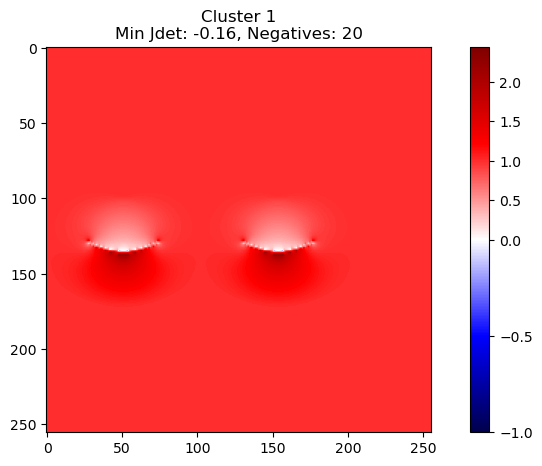

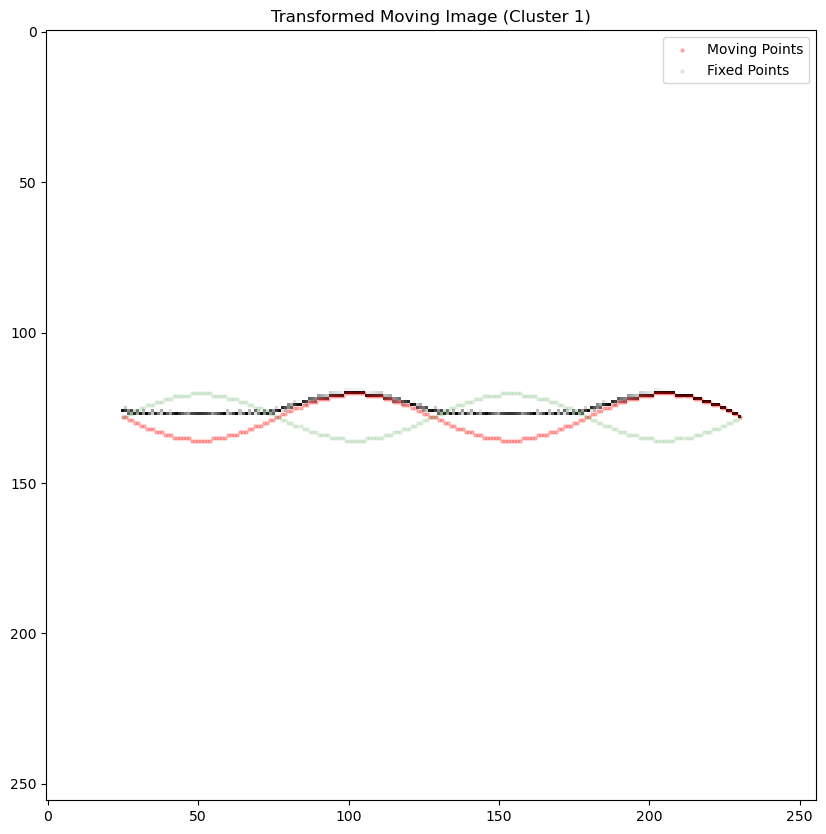

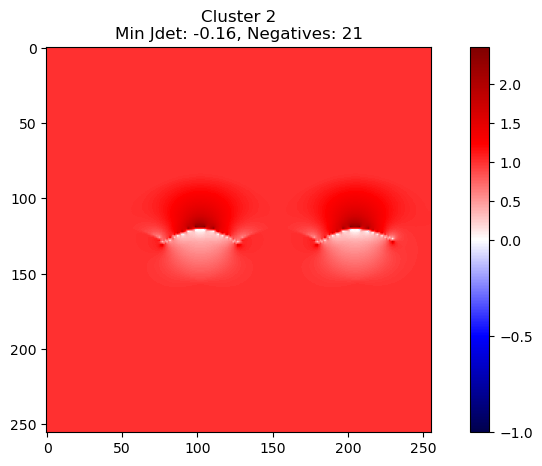

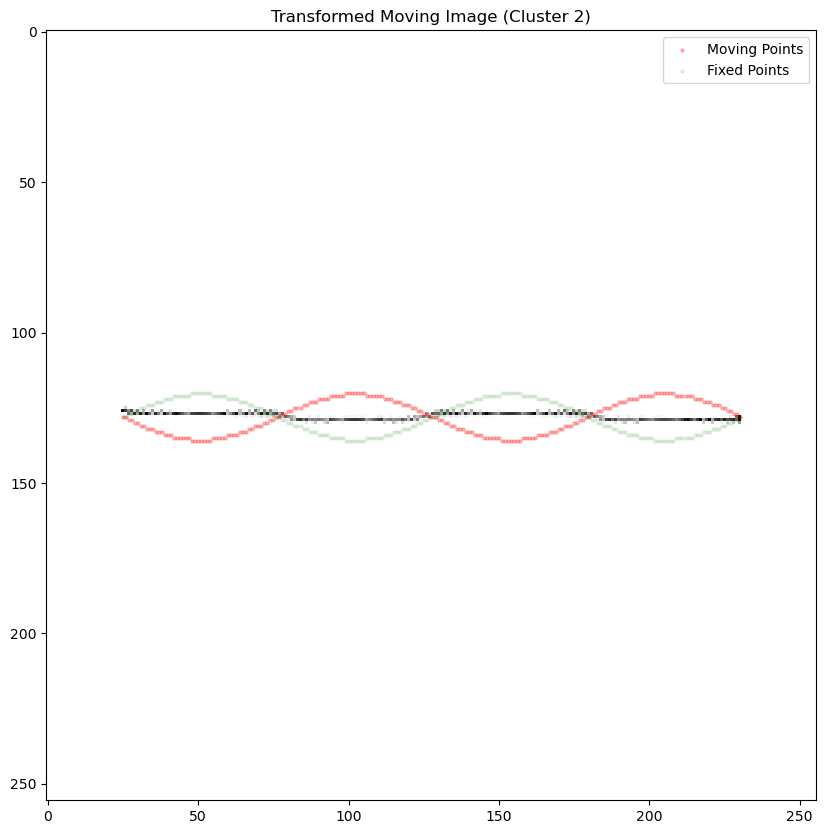

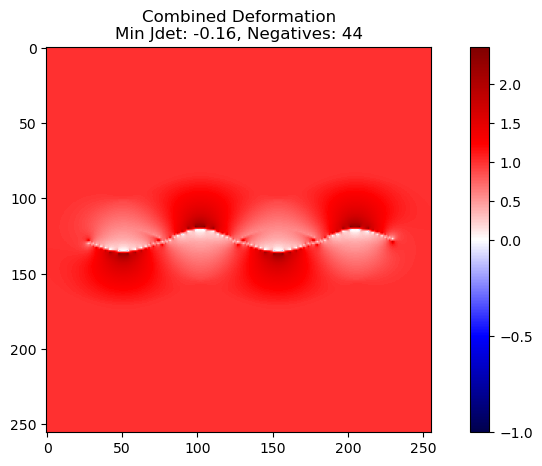

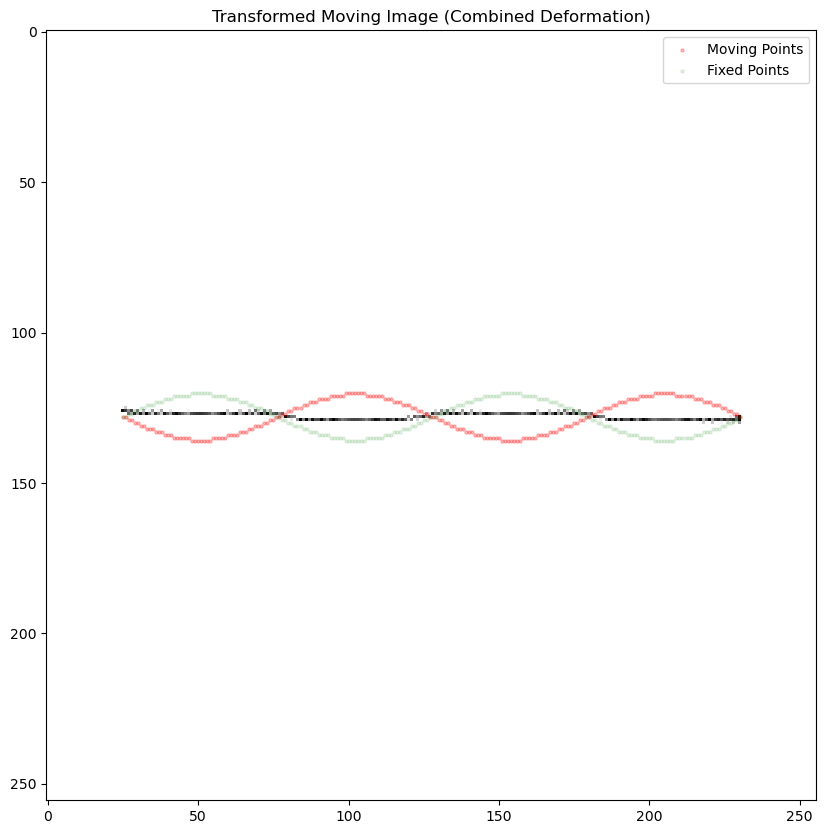

fdata.shape (1, 256, 256)
Time taken to create A:  0.06210684776306152
Total error after cluster-based deformation: 17.47
L2 error between original deformation and cluster-based deformation: 42.54


In [46]:
print("Down indices then up indices")
d_result = cluster_laplacian(helix_wave1, helix_wave2, resolution, [down_indices, up_indices], moving_img)
_, _, _, total_err = compute_error(d_result.resolution, helix_wave1, helix_wave2, d_result.deformation)
print(f"Total error after cluster-based deformation: {total_err:.2f}")
print(f"L2 error between original deformation and cluster-based deformation: {np.linalg.norm(d_original.deformation - d_result.deformation):.2f}")

### Up first

Up indices then down indices


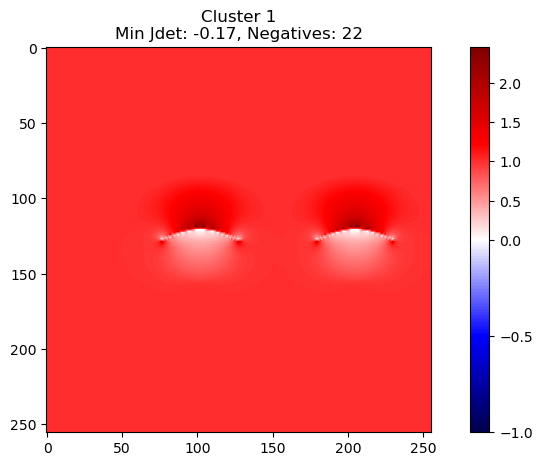

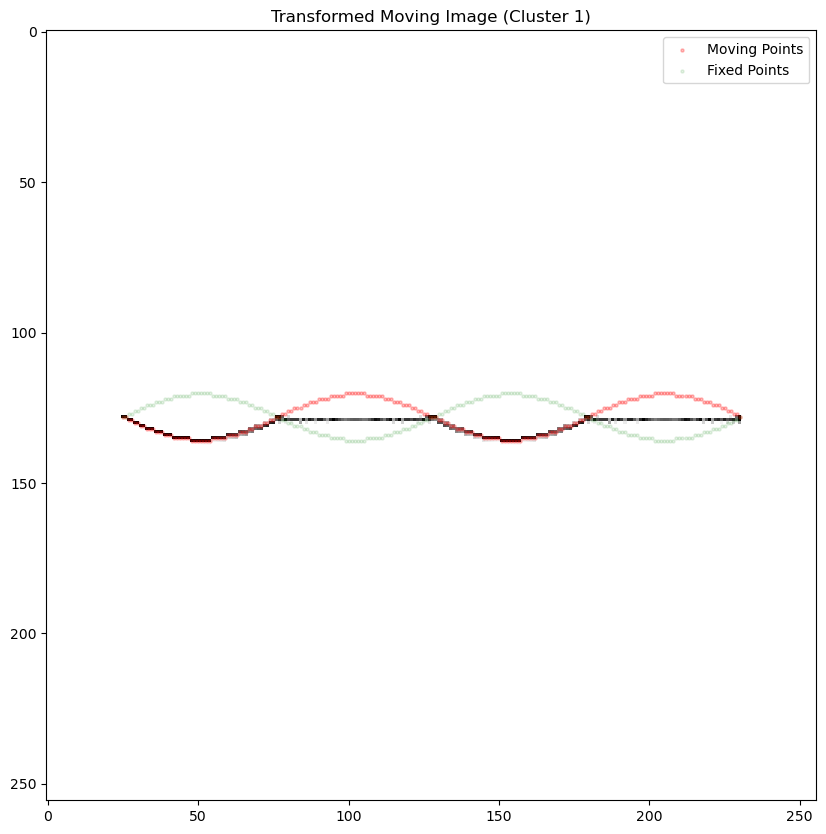

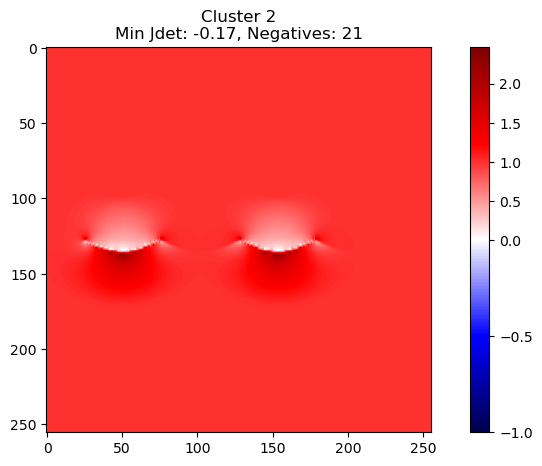

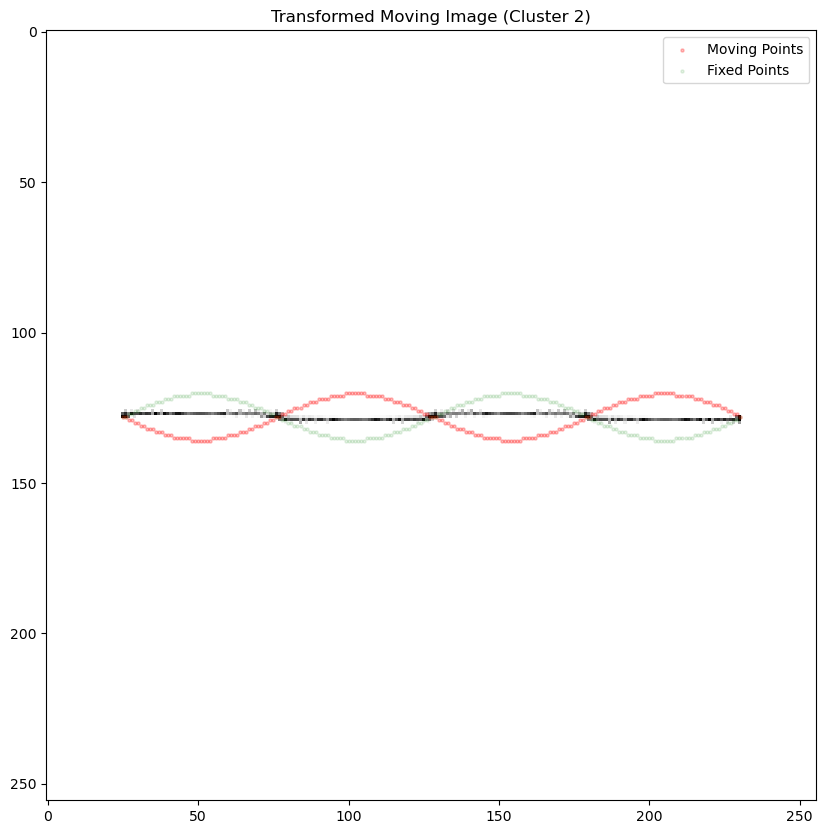

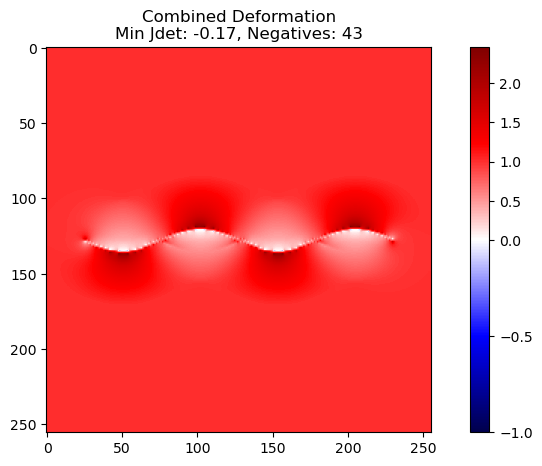

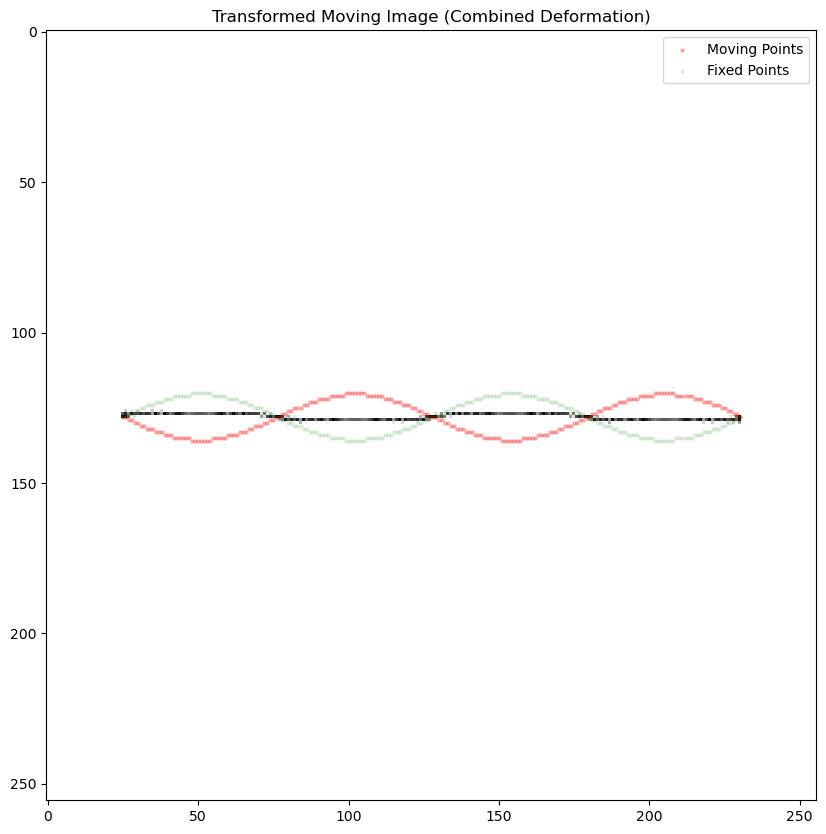

fdata.shape (1, 256, 256)
Time taken to create A:  0.06559348106384277
Total error after cluster-based deformation: 13.15
L2 error between original deformation and cluster-based deformation: 28.03


In [47]:
print("Up indices then down indices")
d_result = cluster_laplacian(helix_wave1, helix_wave2, resolution, [up_indices, down_indices], moving_img)
_, _, _, total_err = compute_error(d_result.resolution, helix_wave1, helix_wave2, d_result.deformation)
print(f"Total error after cluster-based deformation: {total_err:.2f}")
print(f"L2 error between original deformation and cluster-based deformation: {np.linalg.norm(d_original.deformation - d_result.deformation):.2f}")

# End

=== Clustering Double Helix Points by Movement Direction ===
Analyzing 54 point correspondences from double helix

Testing clustering method: y_direction
Analyzing 54 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 1
Cluster 0: 54 points (indices: [0, 1, 2, 3, 4]...)
  Mean displacement: Z=0.000, Y=9.333, X=0.000
  Std displacement:  Z=0.000, Y=5.150, X=0.000


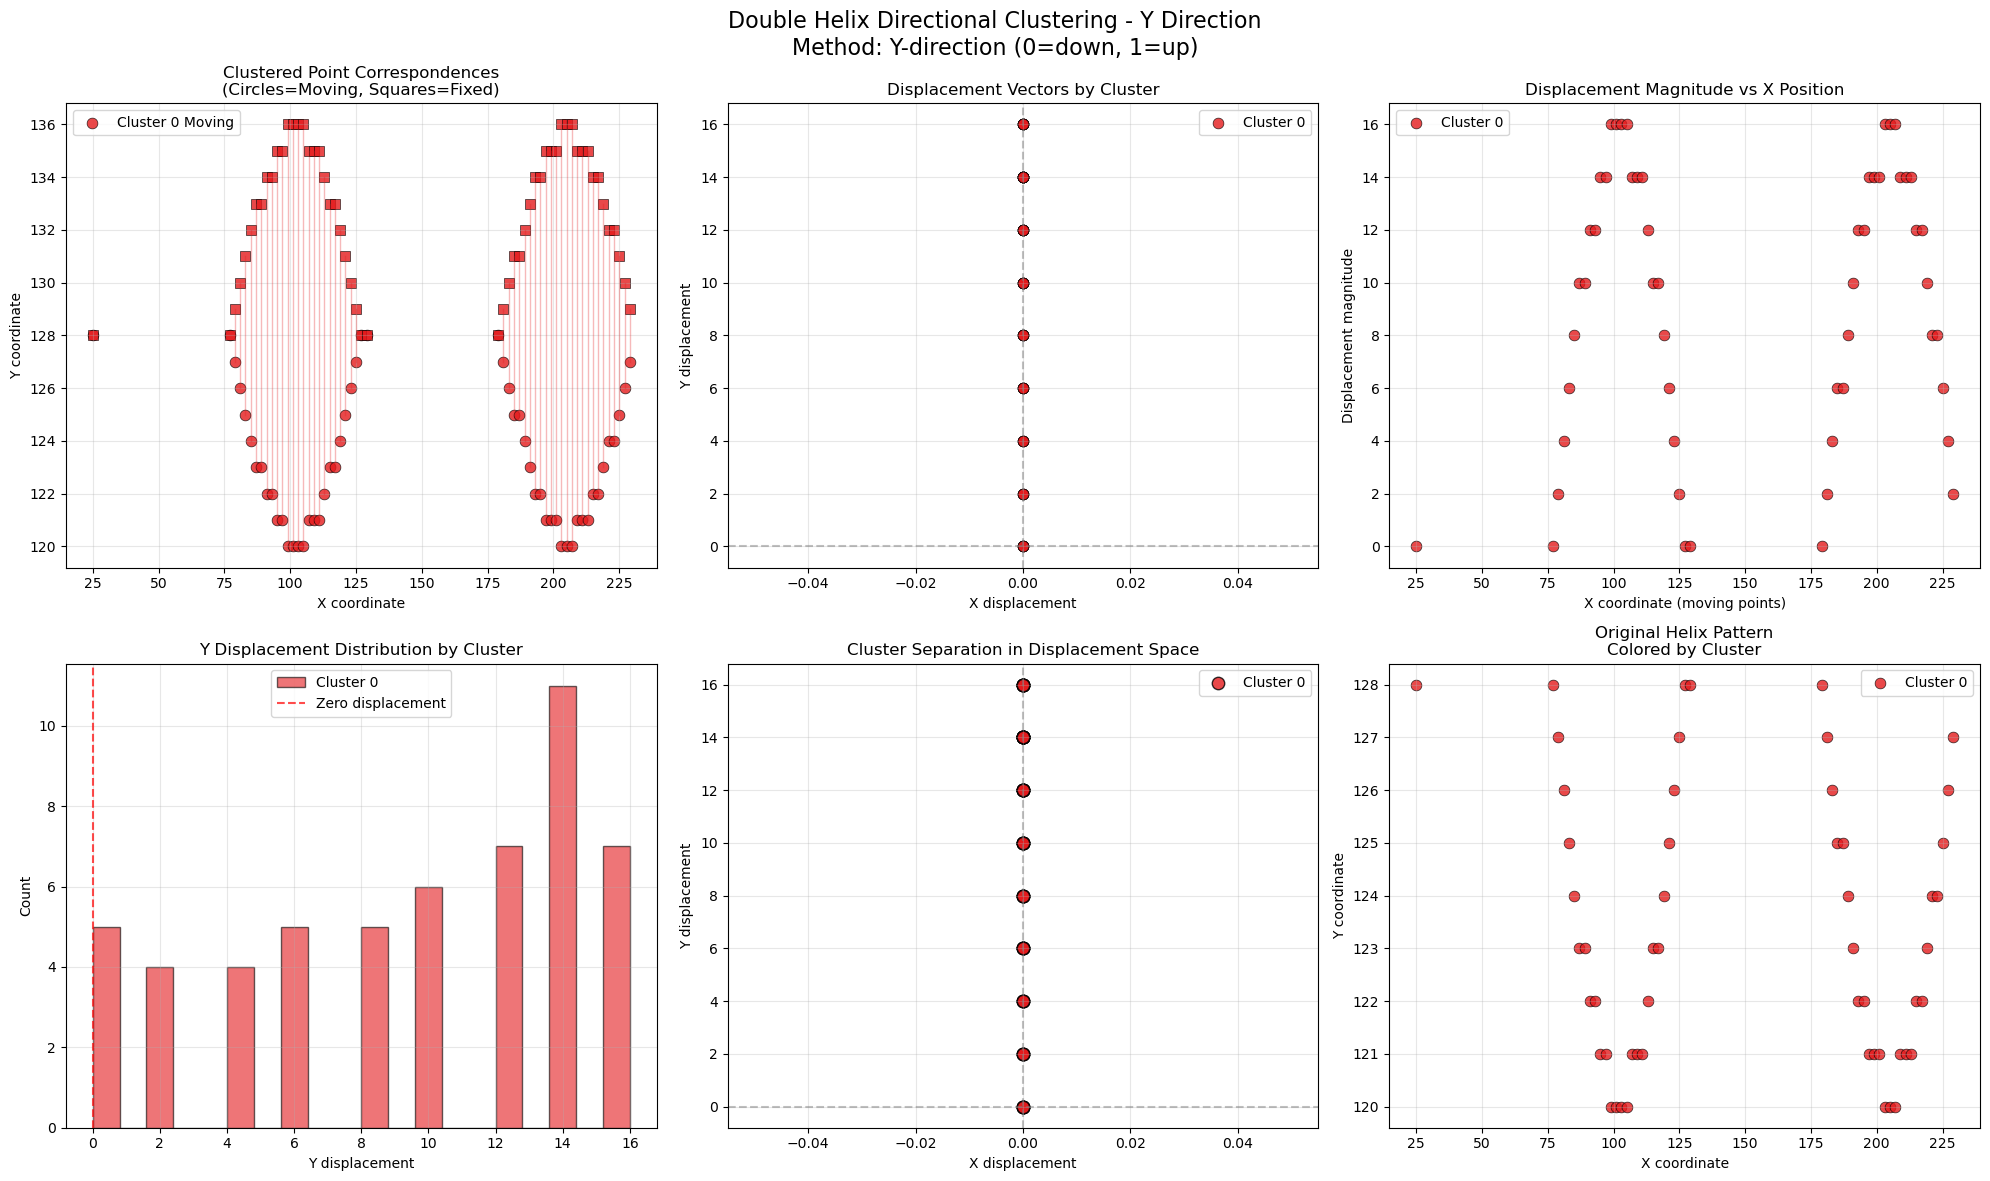


Testing clustering method: quadrant
Analyzing 54 point pairs for directional clustering...
Clustering method: quadrant

Clustering Results (Quadrants (0=+X+Y, 1=-X+Y, 2=-X-Y, 3=+X-Y)):
Number of clusters: 1
Cluster 0: 54 points (indices: [0, 1, 2, 3, 4]...)
  Mean displacement: Z=0.000, Y=9.333, X=0.000
  Std displacement:  Z=0.000, Y=5.150, X=0.000


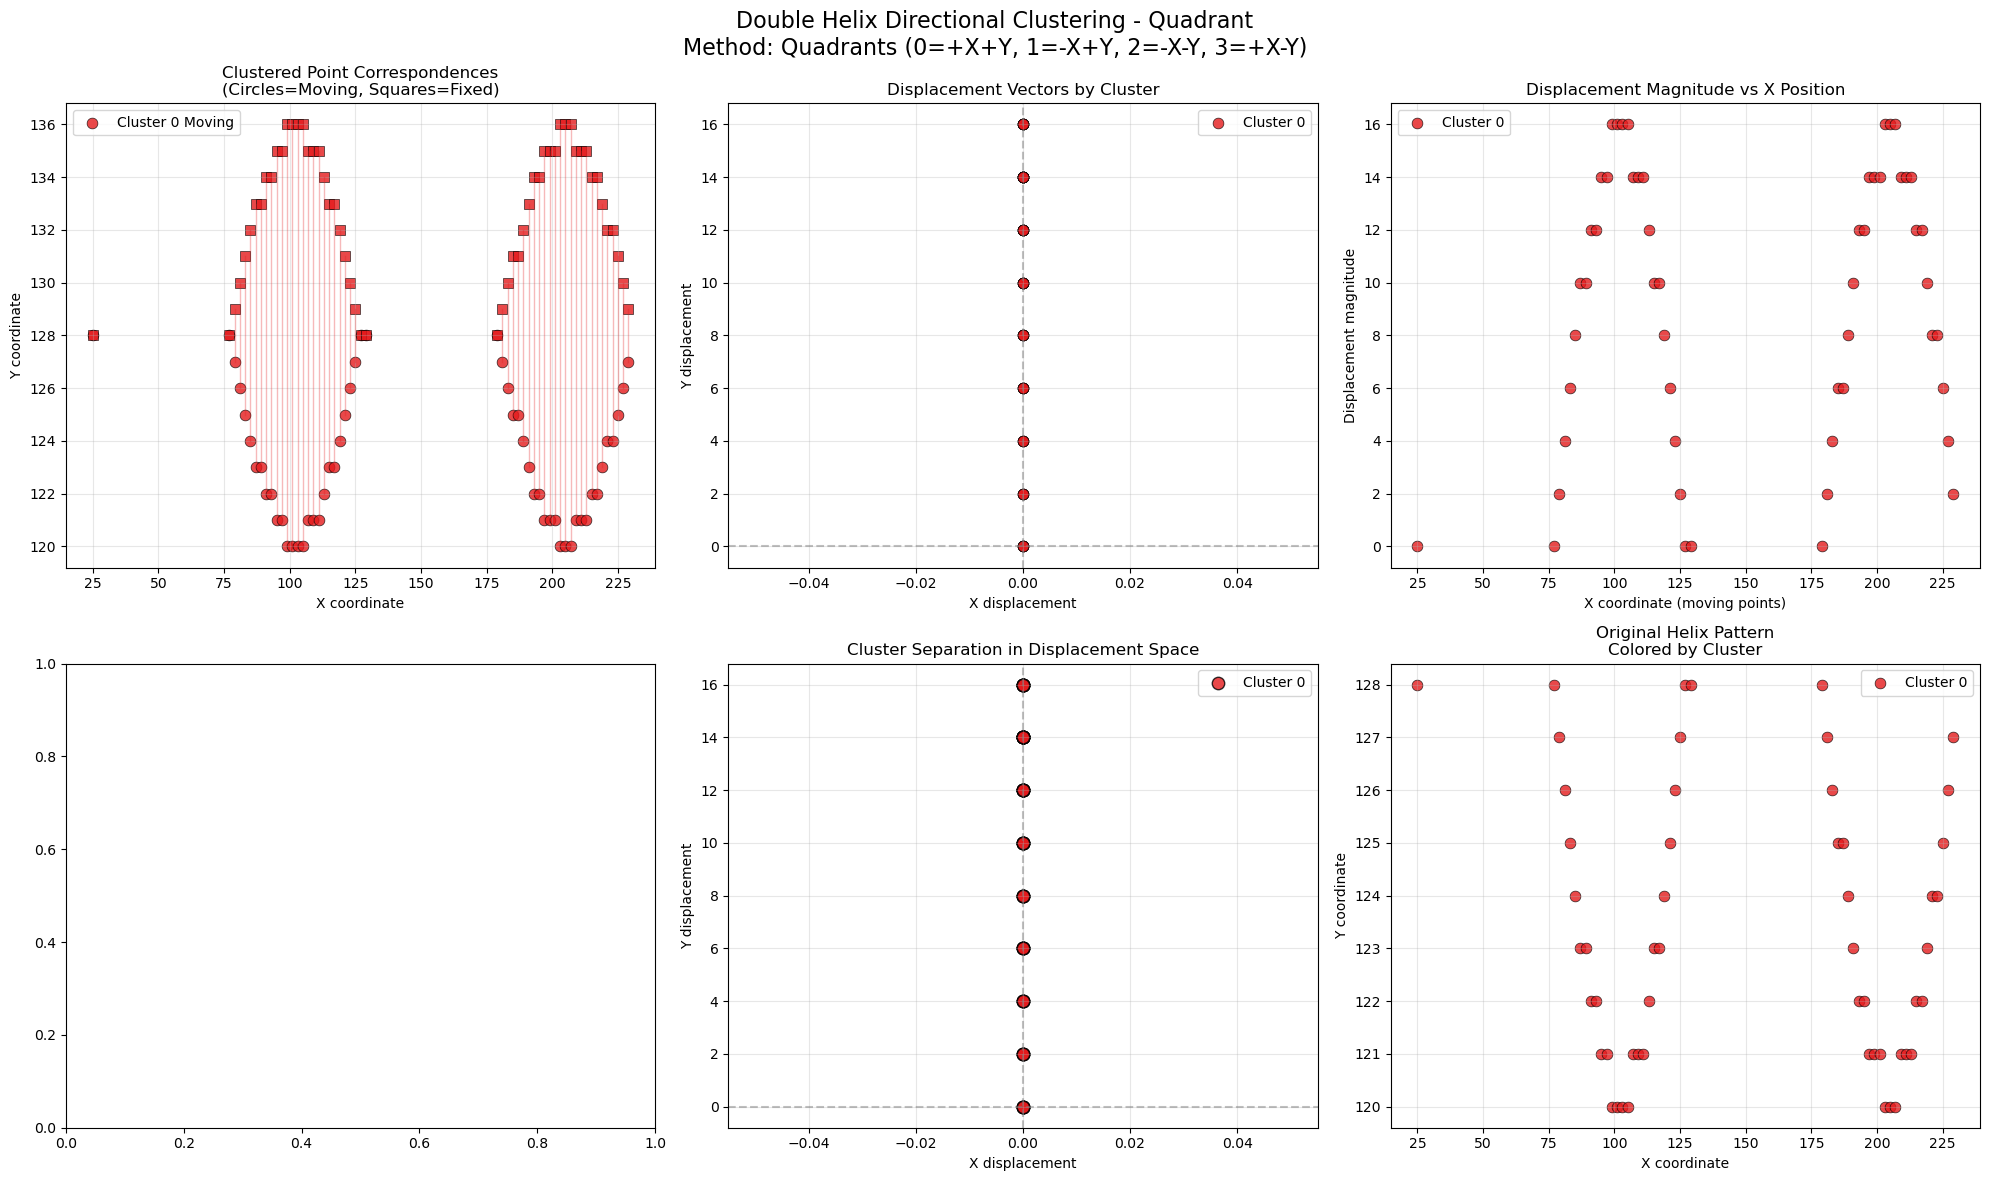


Testing clustering method: displacement_direction
Analyzing 54 point pairs for directional clustering...
Clustering method: displacement_direction

Clustering Results (Directional sectors (n=4)):
Number of clusters: 2
Cluster 0: 5 points (indices: [0, 1, 26, 27, 28])
  Mean displacement: Z=0.000, Y=0.000, X=0.000
  Std displacement:  Z=0.000, Y=0.000, X=0.000
Cluster 1: 49 points (indices: [2, 3, 4, 5, 6]...)
  Mean displacement: Z=0.000, Y=10.286, X=0.000
  Std displacement:  Z=0.000, Y=4.408, X=0.000


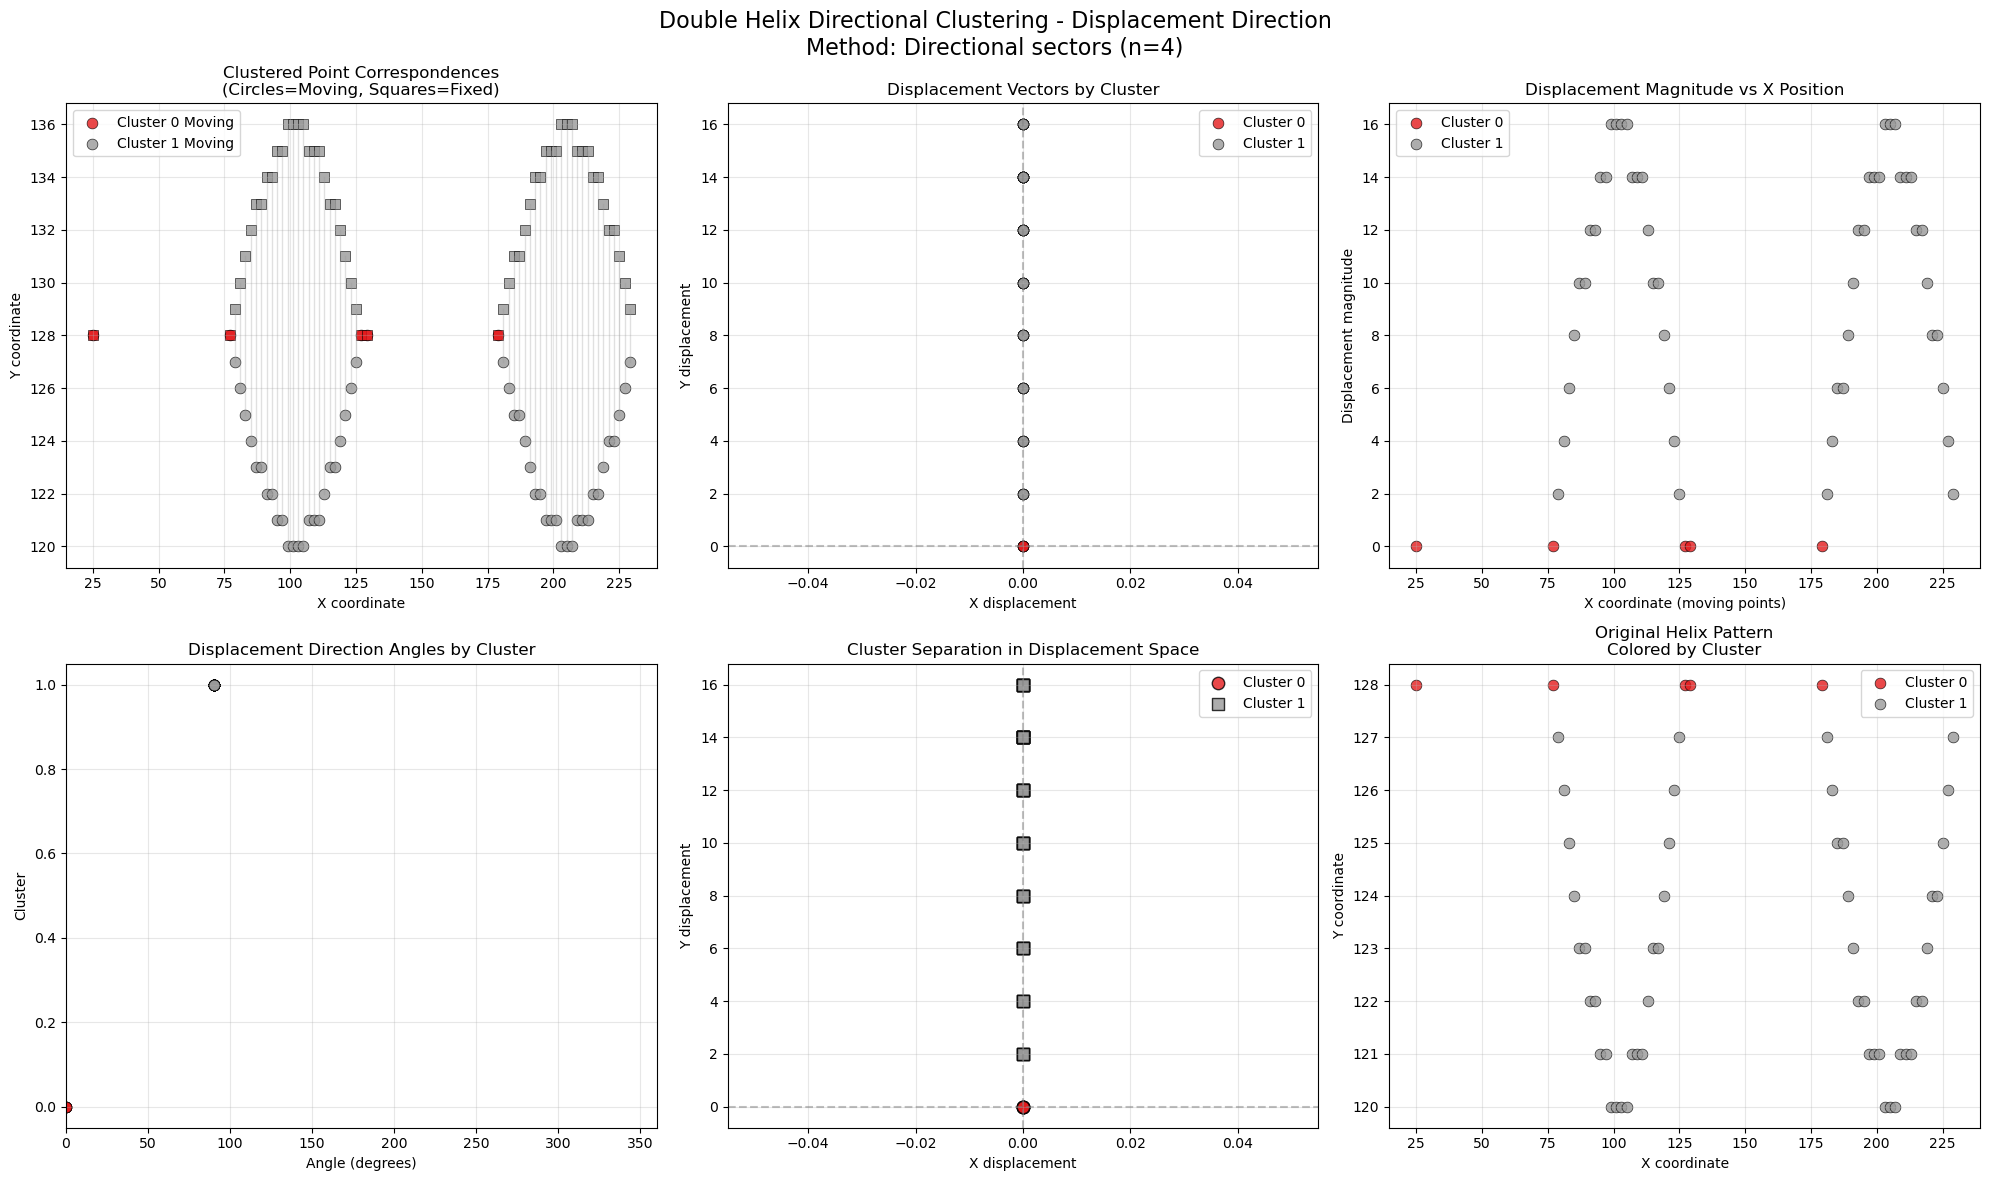


Testing clustering method: helix_phase
Analyzing 54 point pairs for directional clustering...
Clustering method: helix_phase

Clustering Results (Helix phase estimation (3 cycles)):
Number of clusters: 2
Cluster 0: 27 points (indices: [1, 2, 3, 4, 5]...)
  Mean displacement: Z=0.000, Y=9.556, X=0.000
  Std displacement:  Z=0.000, Y=4.939, X=0.000
Cluster 1: 27 points (indices: [0, 10, 11, 12, 13]...)
  Mean displacement: Z=0.000, Y=9.111, X=0.000
  Std displacement:  Z=0.000, Y=5.343, X=0.000


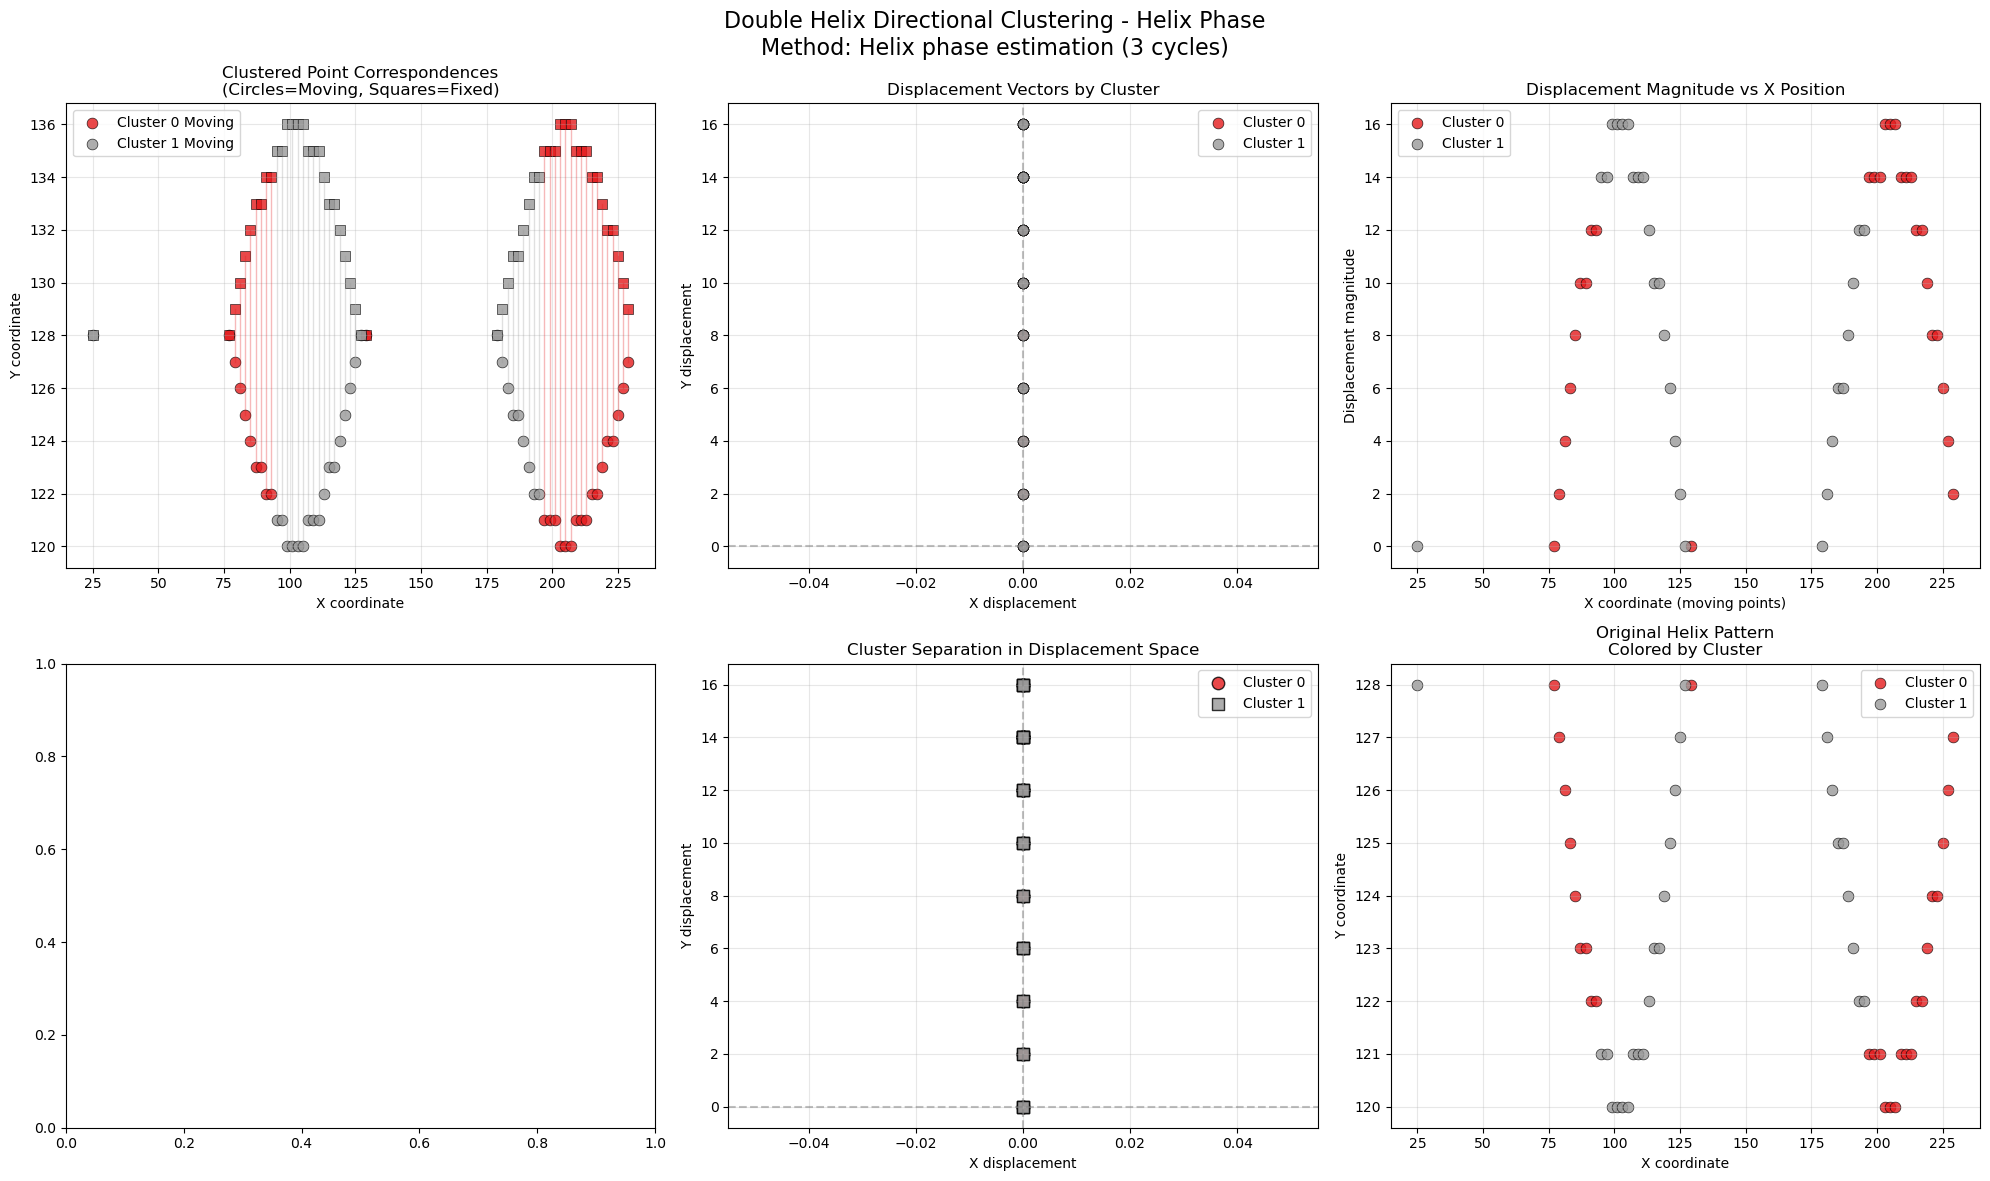

In [17]:
# Example usage with the double helix data
print("=== Clustering Double Helix Points by Movement Direction ===")

# Use the data object from the previous registration
if 'd' in locals():
    original_moving_points = d.mpoints.copy()
    original_fixed_points = d.fpoints.copy()
    
    print(f"Analyzing {len(original_moving_points)} point correspondences from double helix")
    
    # Test different clustering methods
    methods_to_test = ['y_direction', 'quadrant', 'displacement_direction', 'helix_phase']
    
    clustering_results = {}
    
    for method in methods_to_test:
        print(f"\n{'='*50}")
        print(f"Testing clustering method: {method}")
        print(f"{'='*50}")
        
        clusters, labels, displacements = cluster.cluster_by_movement_direction(
            original_moving_points, original_fixed_points, 
            method=method, plot=True, 
            title=f"Double Helix Directional Clustering - {method.replace('_', ' ').title()}"
        )
        
        clustering_results[method] = {
            'clusters': clusters,
            'labels': labels,
            'displacements': displacements
        }
        
else:
    print("No Data object found. Please run the double helix registration first.")